### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19_adjusting_therapeutic_inertia/alabama/2023_10_16_16_12_21/count_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19_adjusting_therapeutic_inertia/alabama/2023_10_16_16_12_21/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw','scenario']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw  scenario       ptvalue
0  25_to_29  Female  2021          29  baseline  29561.023956
1  25_to_29  Female  2021         232  baseline  29333.650924
2  25_to_29  Female  2021         357  baseline  29488.043806
3  25_to_29  Female  2021         394  baseline  29370.907598
4  25_to_29  Female  2021         602  baseline  29263.507187

### BMI

In [5]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2021  high_body_mass_index_in_adults   
1           1  Female  2021  high_body_mass_index_in_adults   
2           2  Female  2021  high_body_mass_index_in_adults   
3           3  Female  2021  high_body_mass_index_in_adults   
4           4  Female  2021  high_body_mass_index_in_adults   

              measure  input_draw  scenario       age          value  
0  risk_exposure_time          29  baseline  25_to_29  911610.597499  
1  risk_exposure_time          29  baseline  30_to_34  891018.662467  
2  risk_exposure_time          29  baseline  35_to_39  869248.301381  
3  risk_exposure_time          29  baseline  40_to_44  835901.173697  
4  risk_exposure_time          29  baseline  45_to_49  879615.497640

In [6]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2021  high_body_mass_index_in_adults   
1           1  Female  2021  high_body_mass_index_in_adults   
2           2  Female  2021  high_body_mass_index_in_adults   
3           3  Female  2021  high_body_mass_index_in_adults   
4           4  Female  2021  high_body_mass_index_in_adults   

              measure  input_draw  scenario       age          value  
0  risk_exposure_time          29  baseline  25_to_29  911610.597499  
1  risk_exposure_time          29  baseline  30_to_34  891018.662467  
2  risk_exposure_time          29  baseline  35_to_39  869248.301381  
3  risk_exposure_time          29  baseline  40_to_44  835901.173697  
4  risk_exposure_time          29  baseline  45_to_49  879615.497640

In [7]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
bmi_exp_rate = bmi_exp_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']],on=['age','sex','year','input_draw','scenario'])
#bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
#bmi_exp_rate_summ_bmi = (bmi_exp_rate
#                .groupby(['age', 'sex', 'year','scenario'])
#                .value.describe(percentiles=[.025,0.5, .975])
#                .filter(['mean', '50%','2.5%', '97.5%'])
#                .reset_index())
#bmi_exp_rate_summ_ptvalue = (bmi_exp_rate
#                .groupby(['age', 'sex', 'year','scenario'])
#                .ptvalue.describe(percentiles=[.025,0.5, .975])
#                .filter(['mean', '50%','2.5%', '97.5%'])
#                .reset_index())
bmi_exp_rate_summ.head()

age     sex  year  scenario       mean        50%       2.5%  \
0  25_to_29  Female  2021  baseline  30.719063  30.697050  30.344808   
1  25_to_29  Female  2022  baseline  30.712985  30.680515  30.378378   
2  25_to_29  Female  2023  baseline  30.690025  30.644752  30.420901   
3  25_to_29  Female  2024  baseline  30.699502  30.658514  30.424389   
4  25_to_29  Female  2025  baseline  30.688488  30.670393  30.393945   

       97.5%  
0  31.062583  
1  31.034765  
2  30.971266  
3  30.967996  
4  30.905162

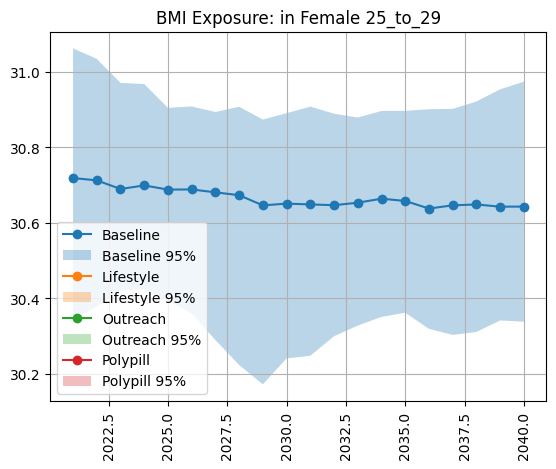

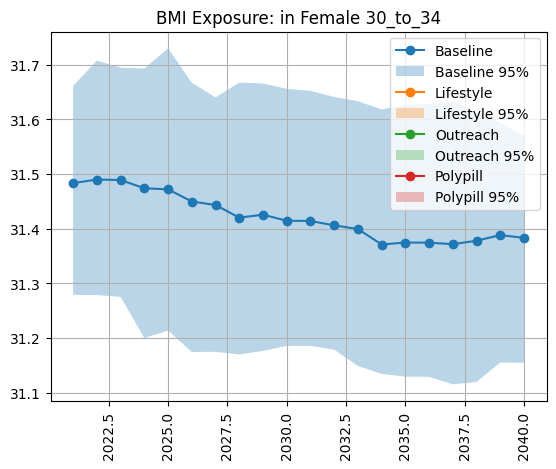

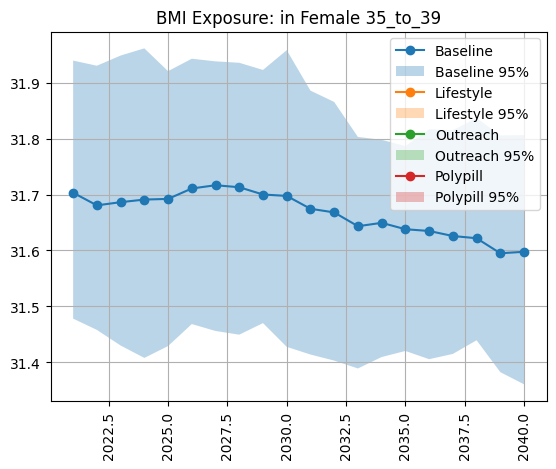

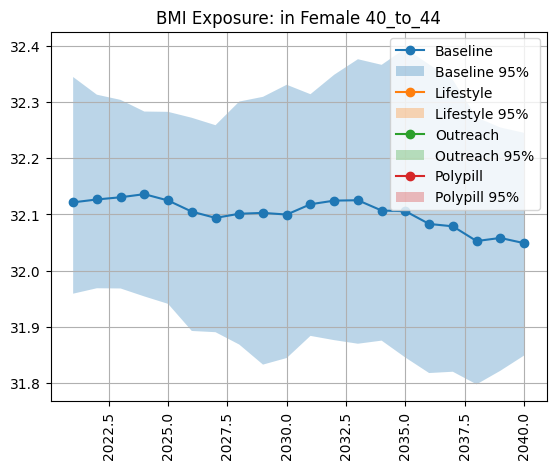

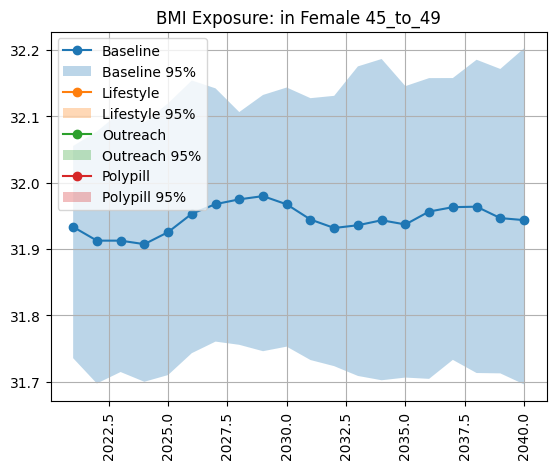

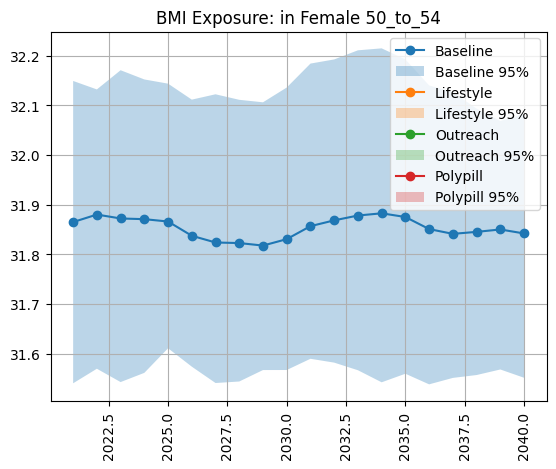

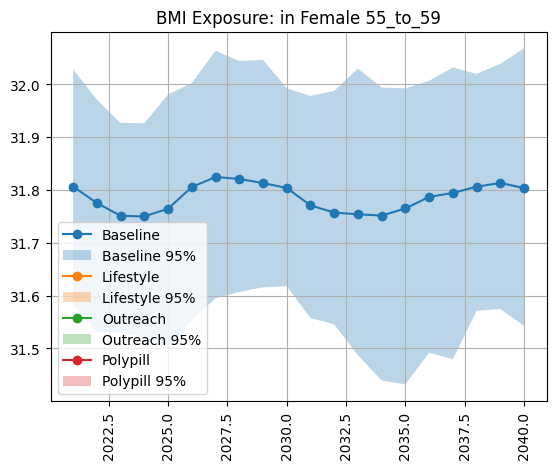

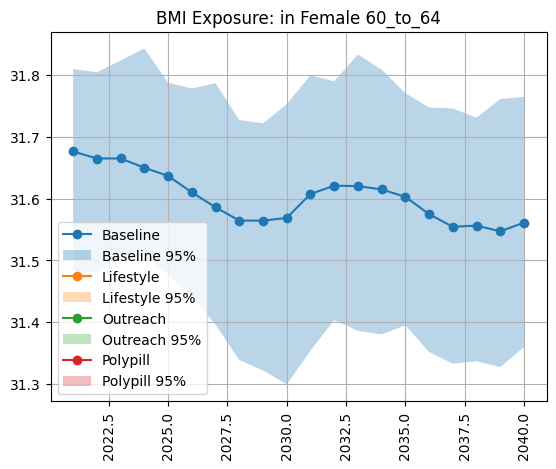

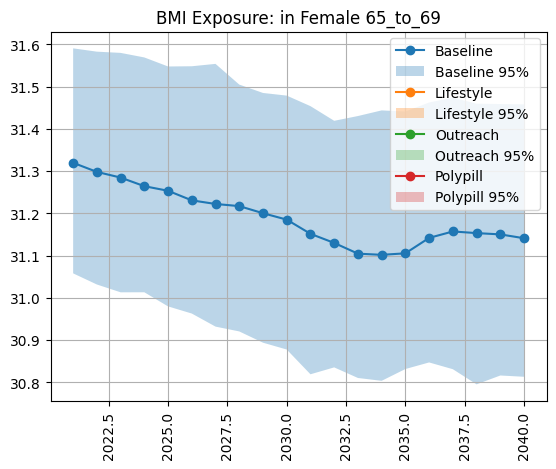

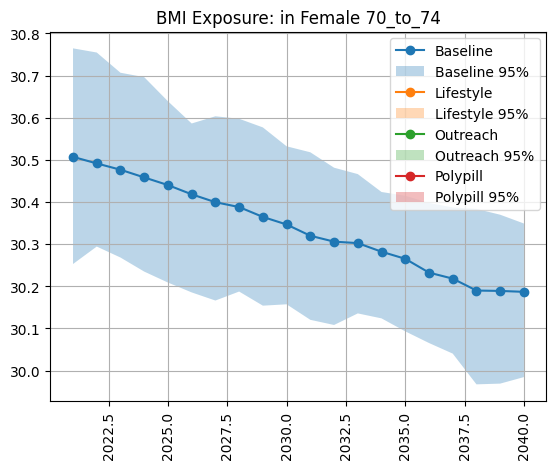

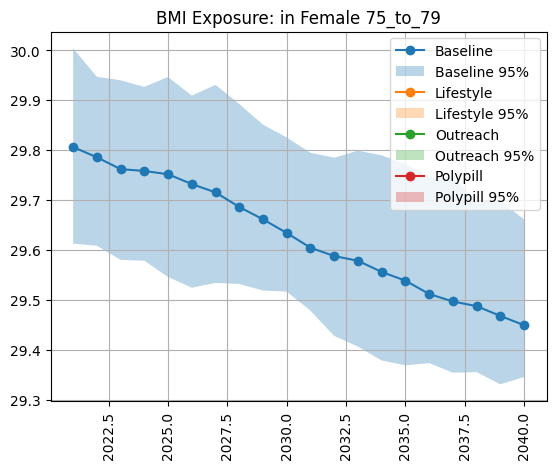

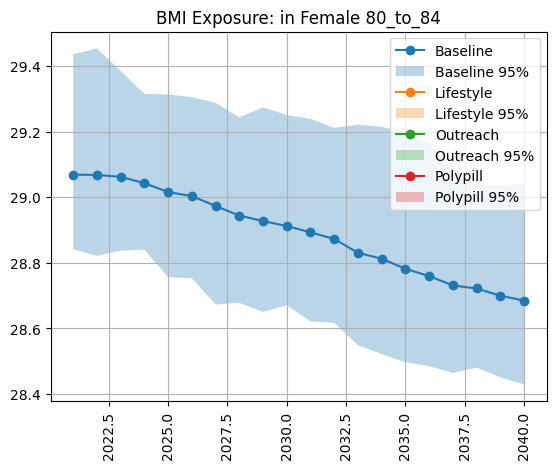

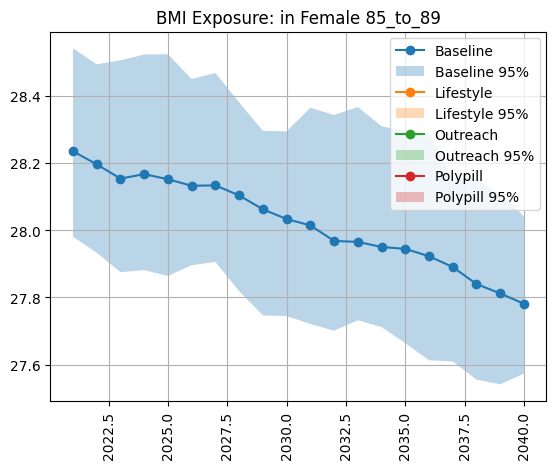

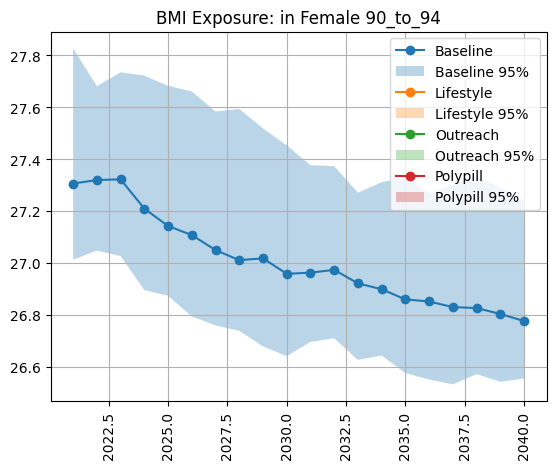

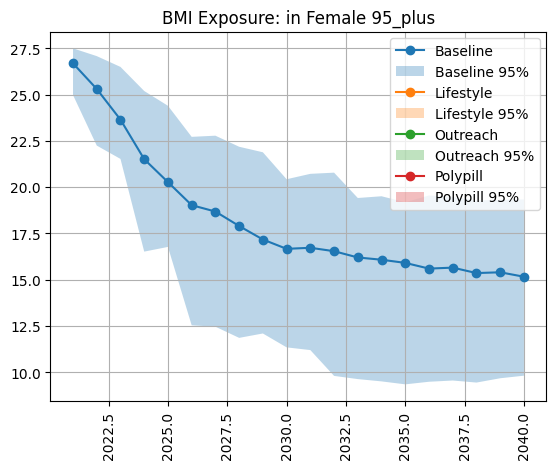

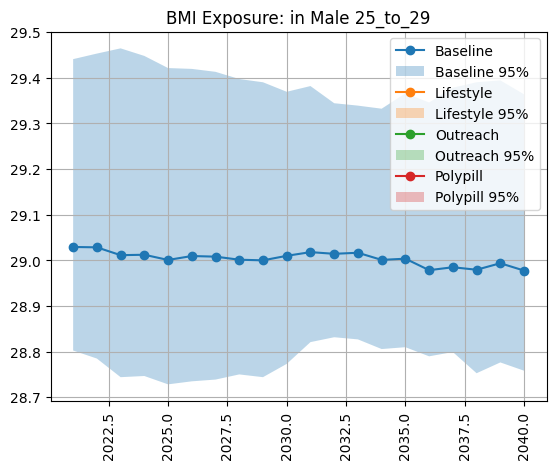

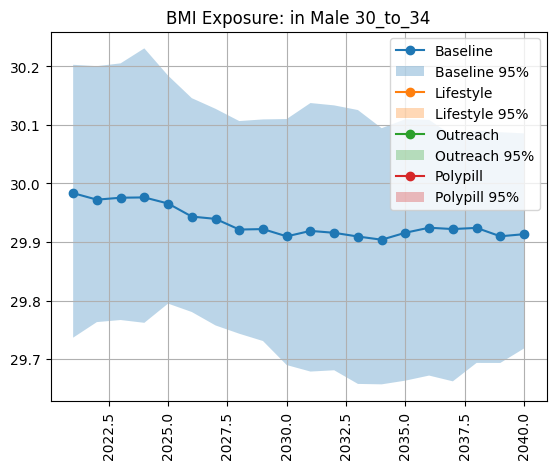

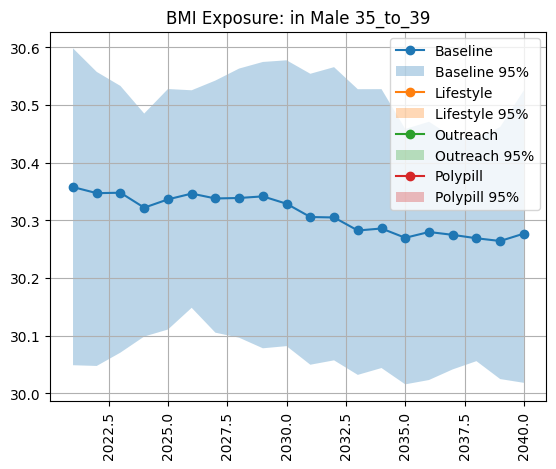

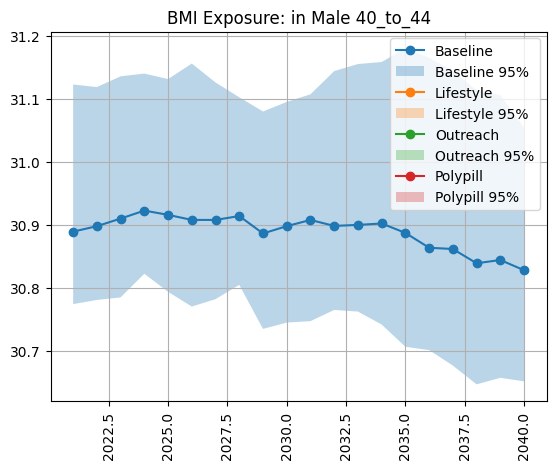

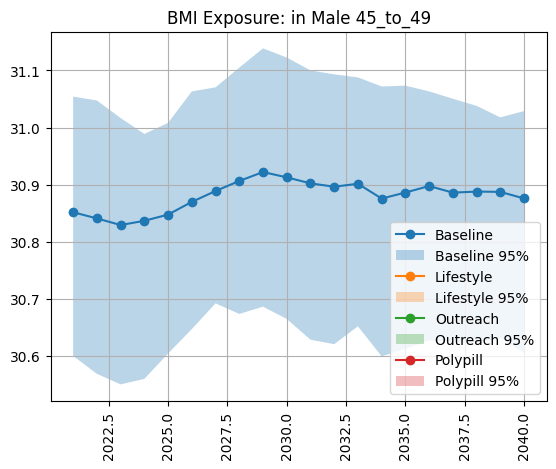

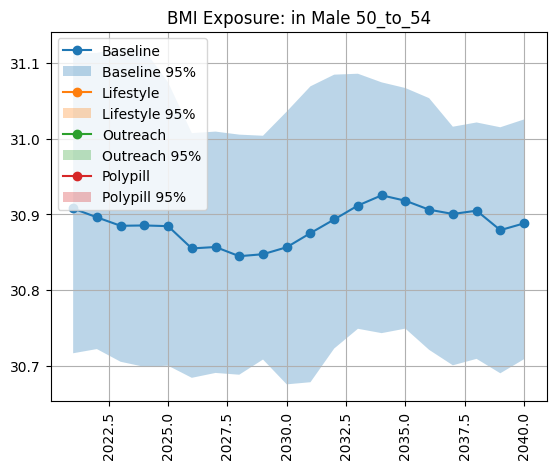

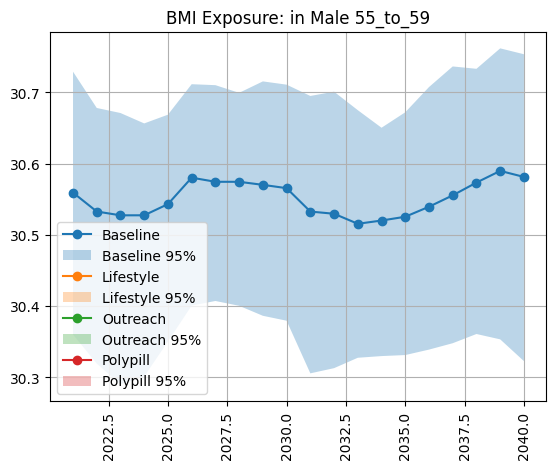

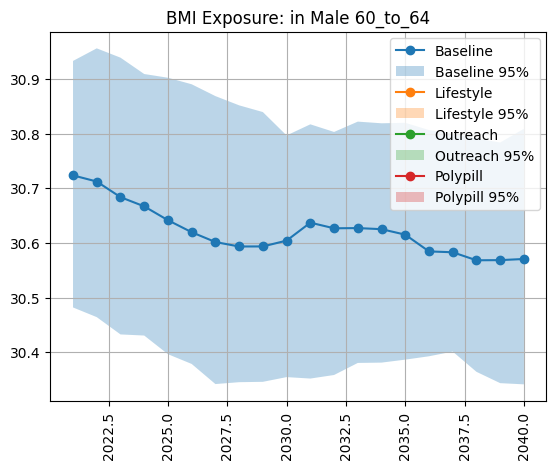

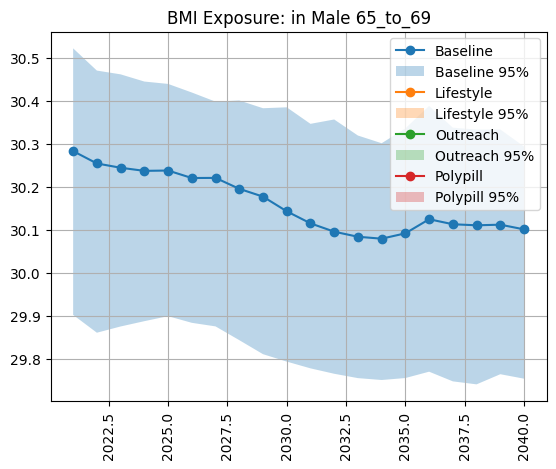

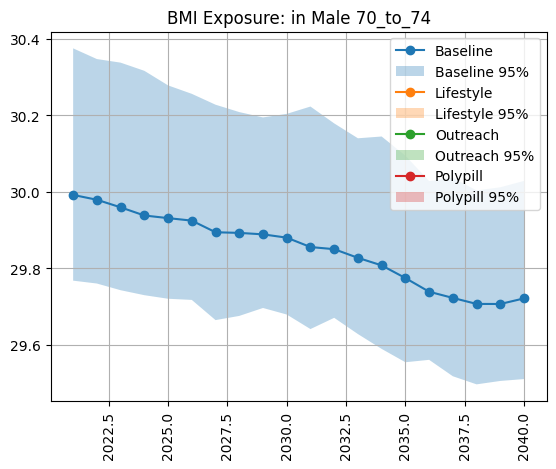

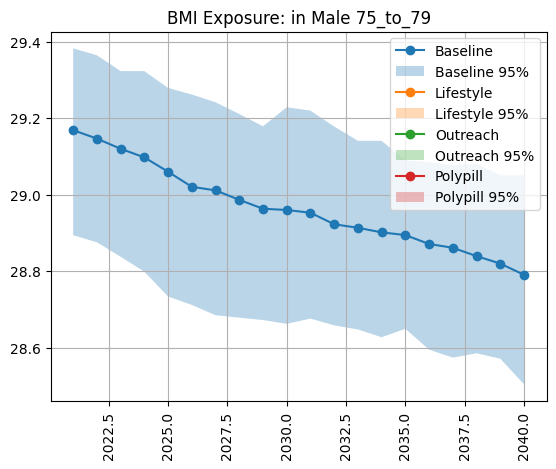

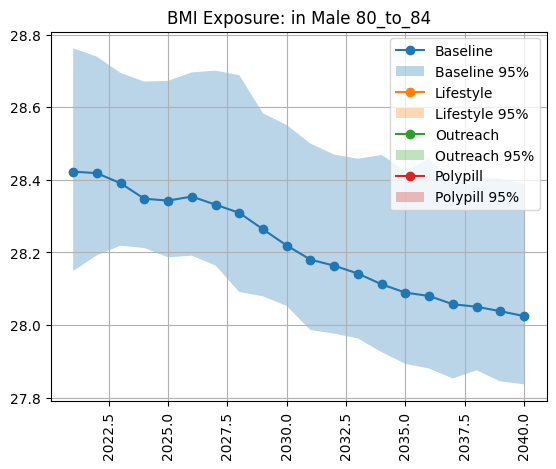

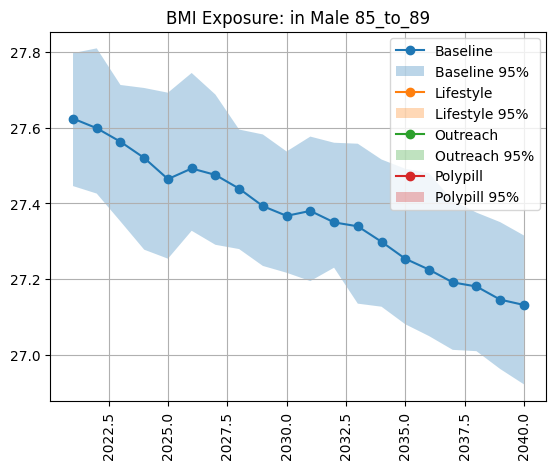

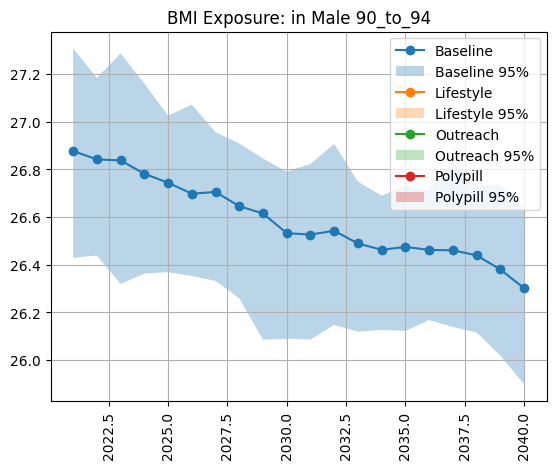

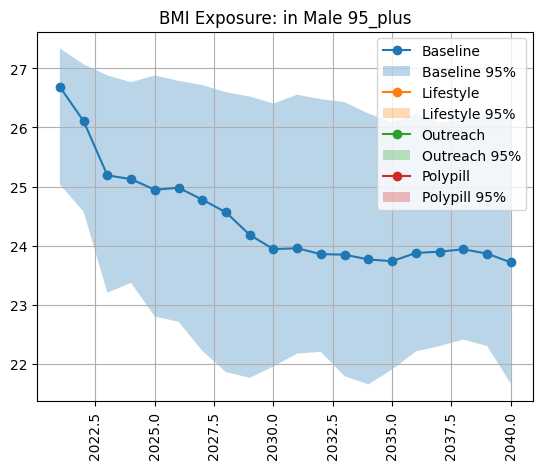

In [8]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age) & (bmi_exp_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
        plt.title(f'BMI Exposure: in {sex} {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(20,33)
        plt.grid()

As expected, lifestyle is the only scenario with a real change in BMI. This is good as it is the only one that directly affects BMI and nothing is correlated yet! 

### SBP 

In [9]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

age     sex  year  scenario        mean        2.5%       97.5%
0  25_to_29  Female  2021  baseline  110.138538  107.905866  112.947614
1  25_to_29  Female  2022  baseline  110.070269  107.886550  112.805669
2  25_to_29  Female  2023  baseline  109.961904  107.766709  112.698614
3  25_to_29  Female  2024  baseline  109.961608  107.791934  112.629208
4  25_to_29  Female  2025  baseline  109.916473  107.764075  112.552309

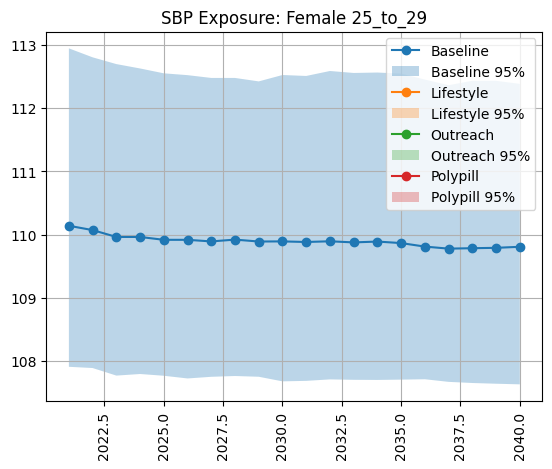

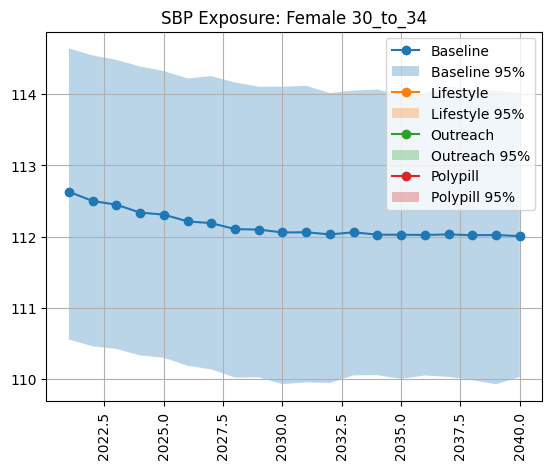

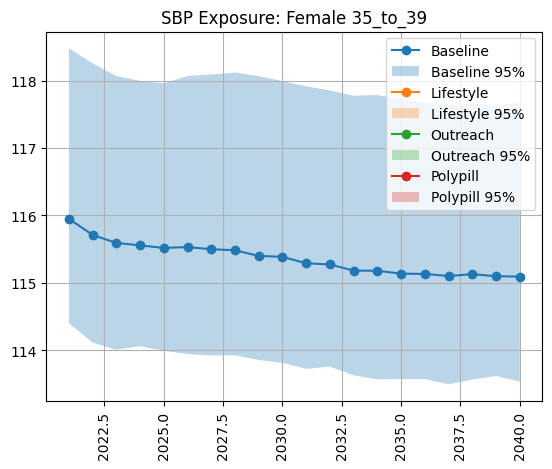

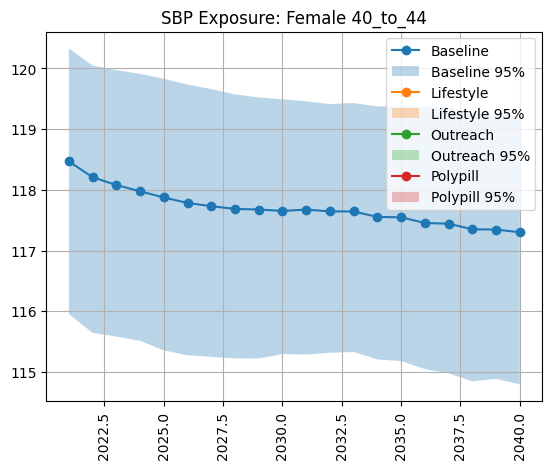

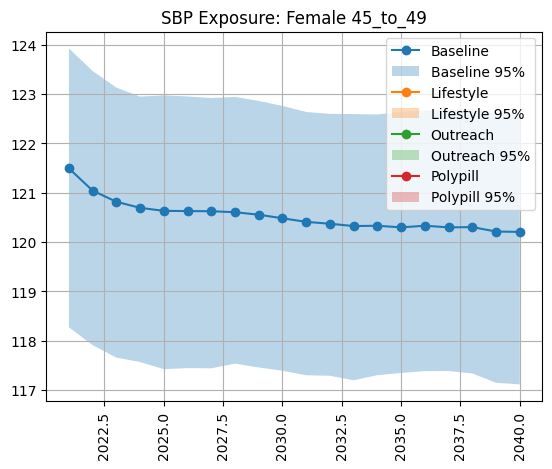

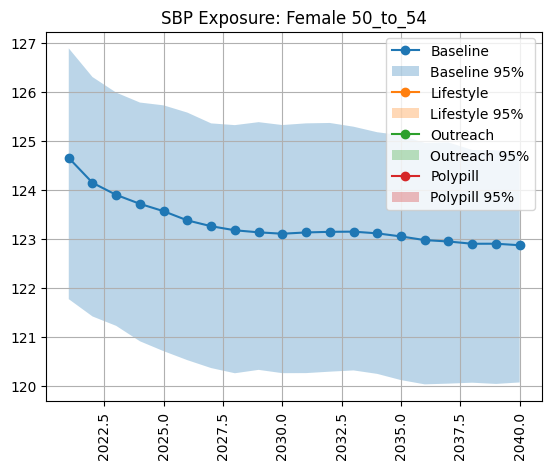

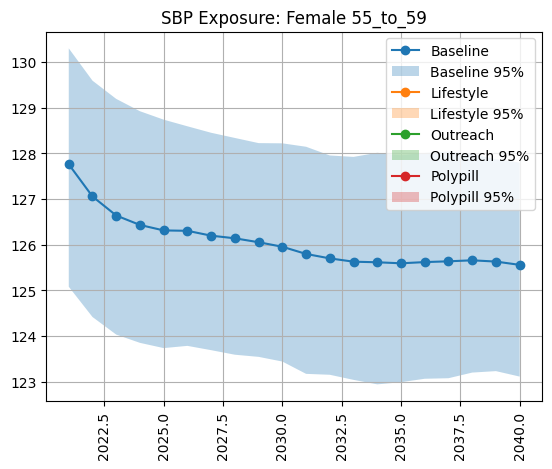

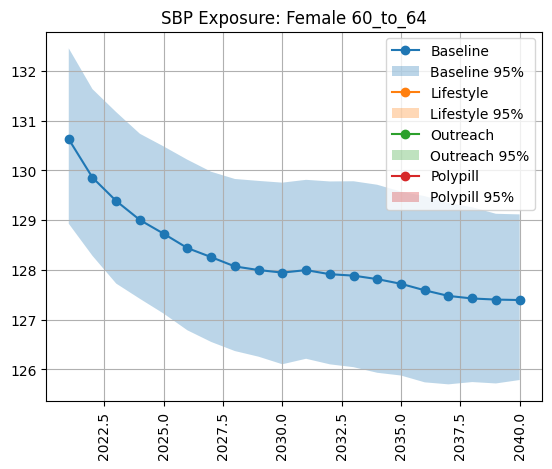

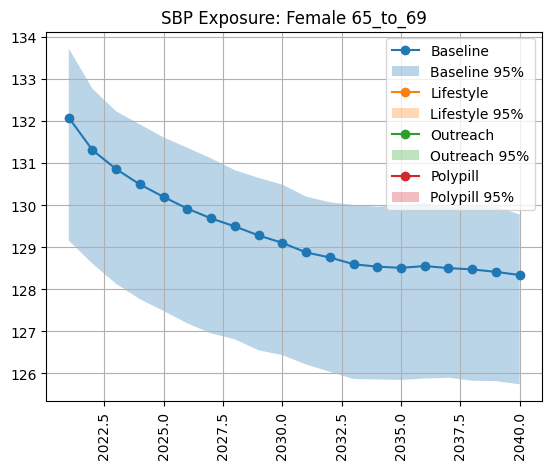

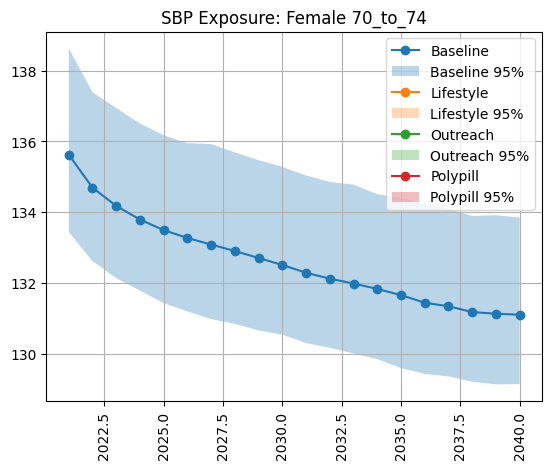

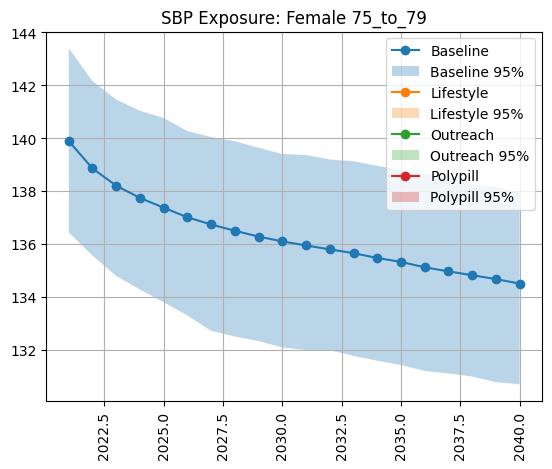

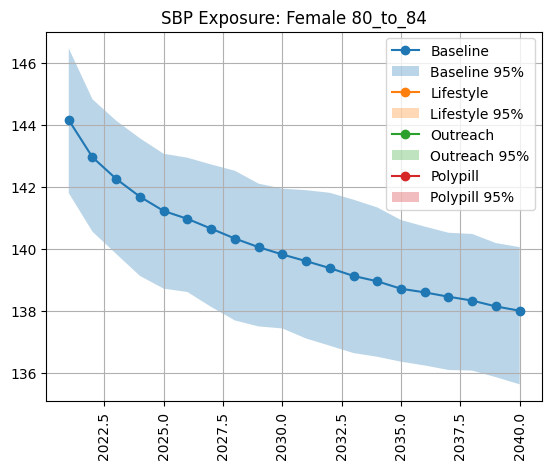

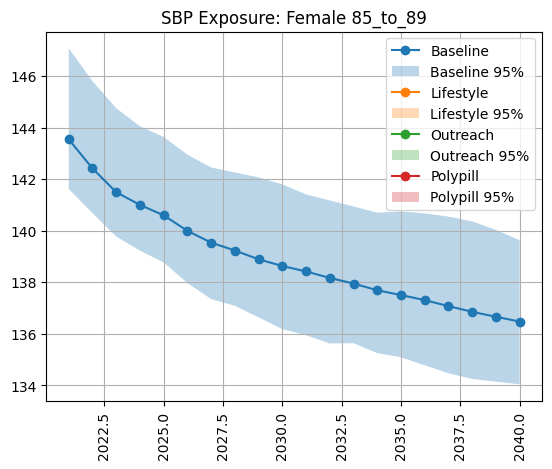

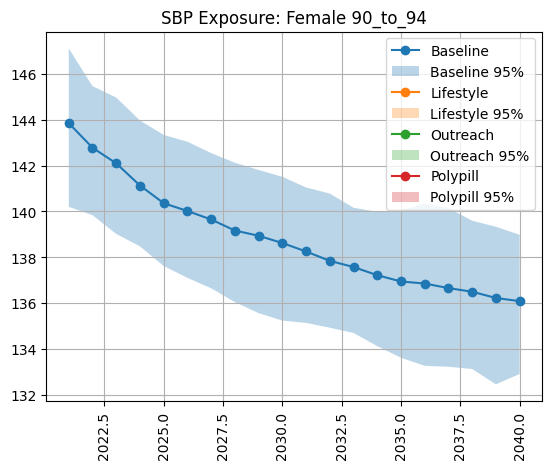

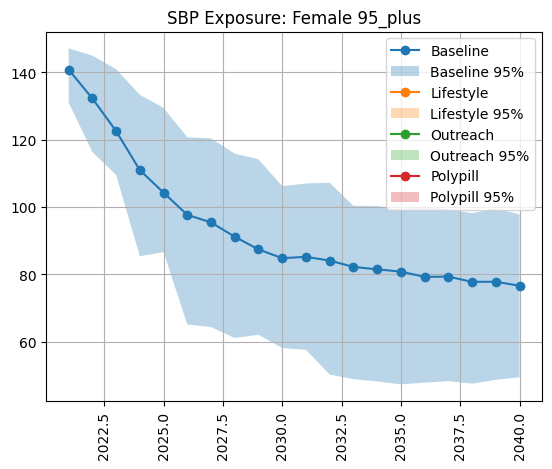

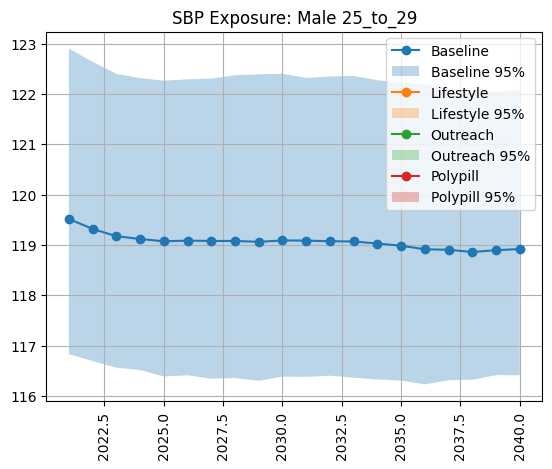

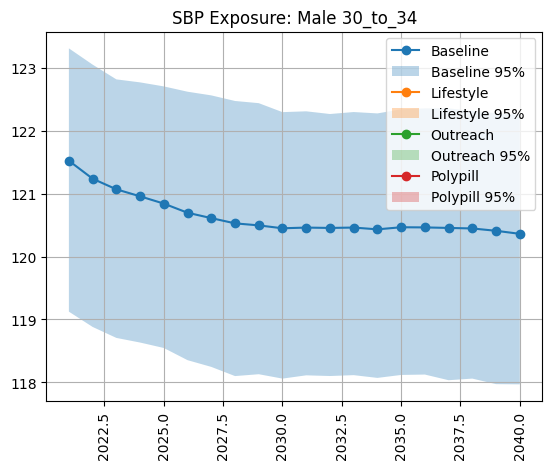

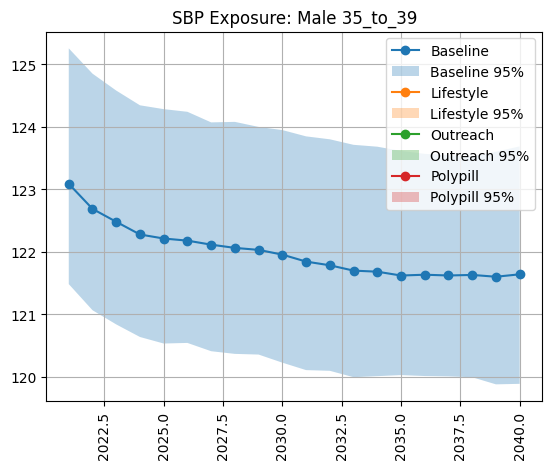

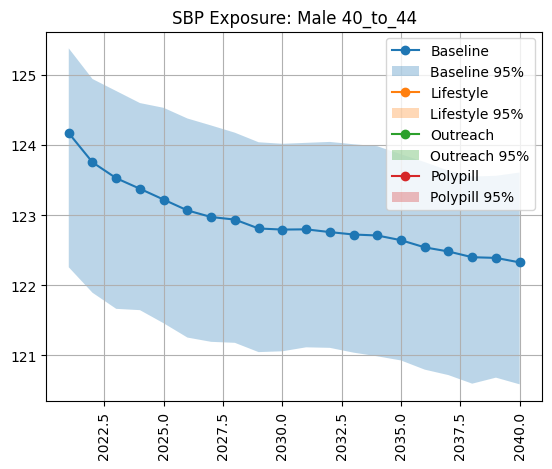

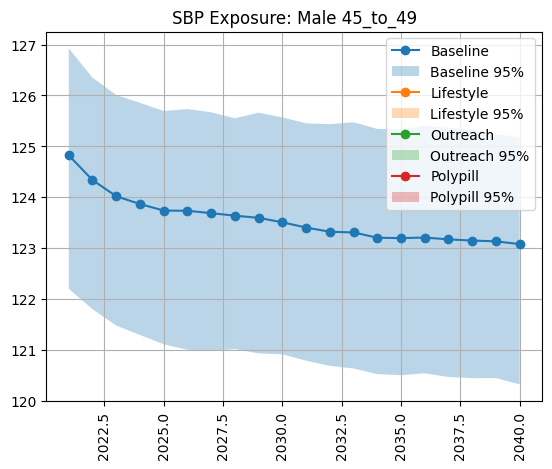

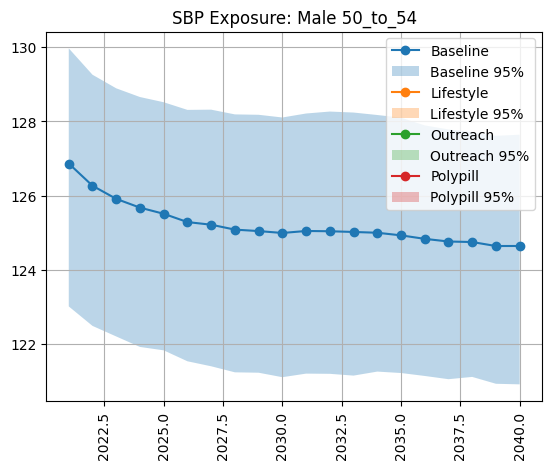

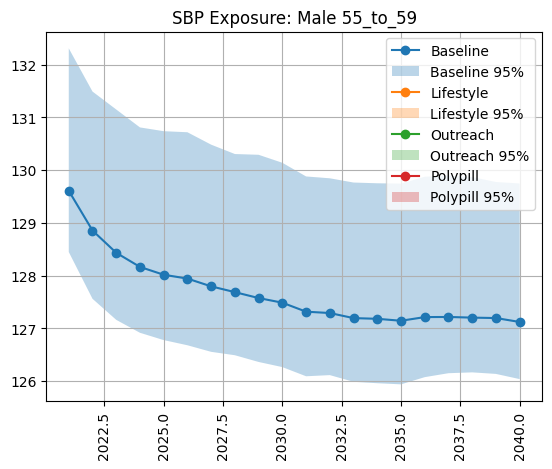

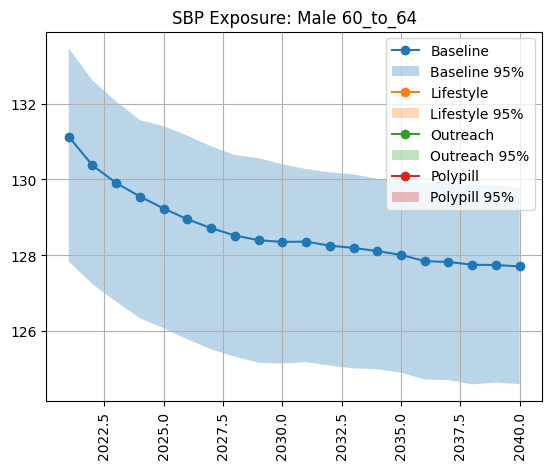

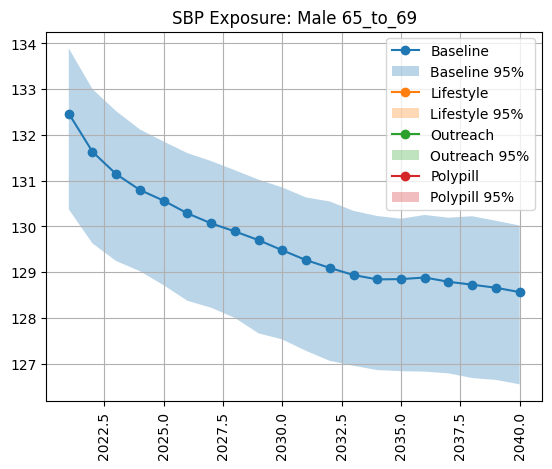

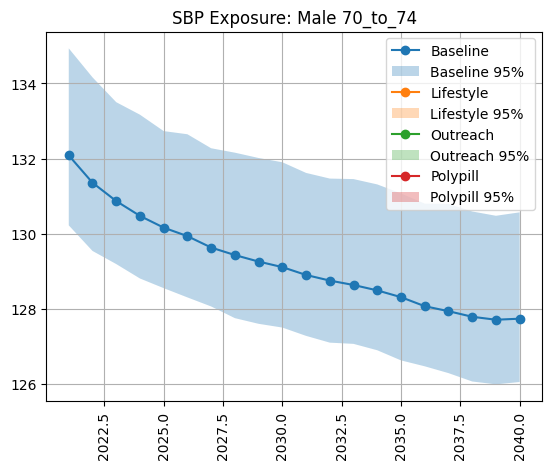

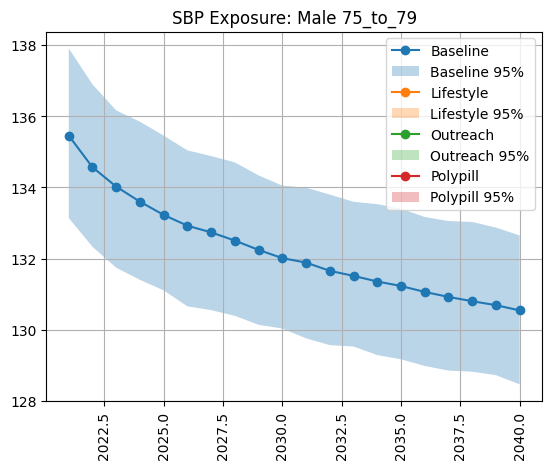

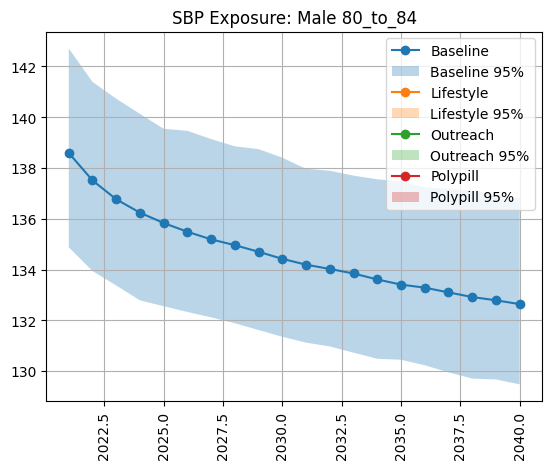

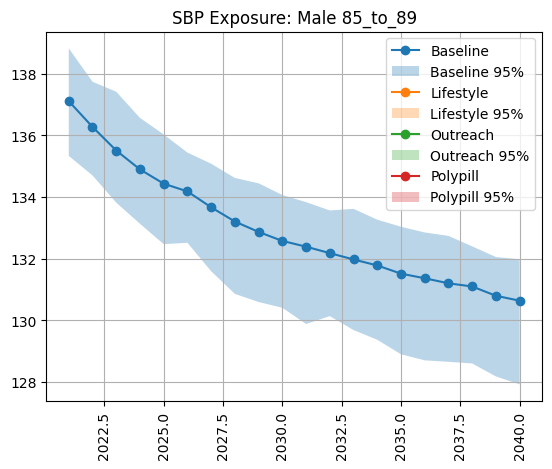

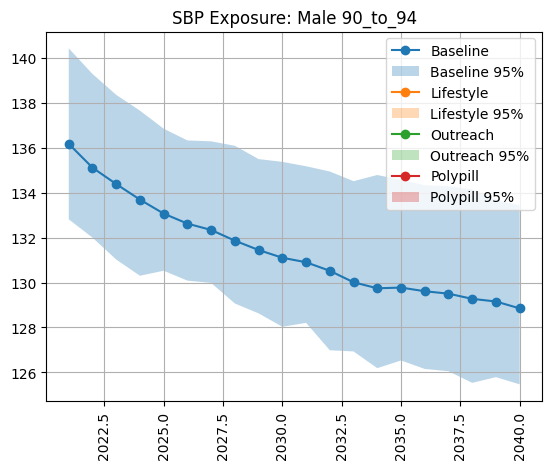

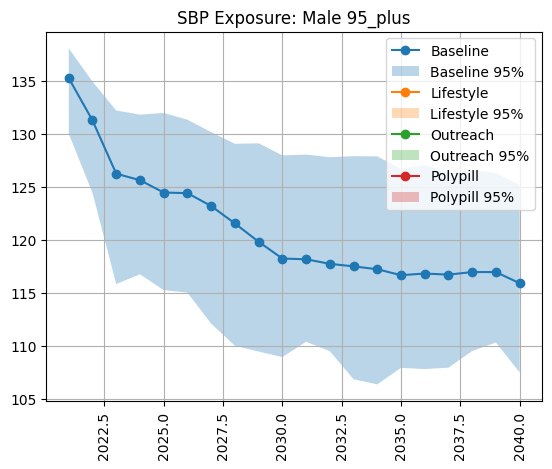

In [10]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age) & (sbp_exp_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
        plt.title(f'SBP Exposure: {sex} {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Polypill and outreach have a visible impact on SBP as expected. Lifestyle has a slight effect as expected. 

### LDL-C

In [11]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

age     sex  year  scenario      mean      2.5%     97.5%
0  25_to_29  Female  2021  baseline  2.632283  2.548315  2.805775
1  25_to_29  Female  2022  baseline  2.632318  2.546310  2.804873
2  25_to_29  Female  2023  baseline  2.631225  2.545407  2.805880
3  25_to_29  Female  2024  baseline  2.630782  2.546987  2.805139
4  25_to_29  Female  2025  baseline  2.629090  2.544724  2.797970

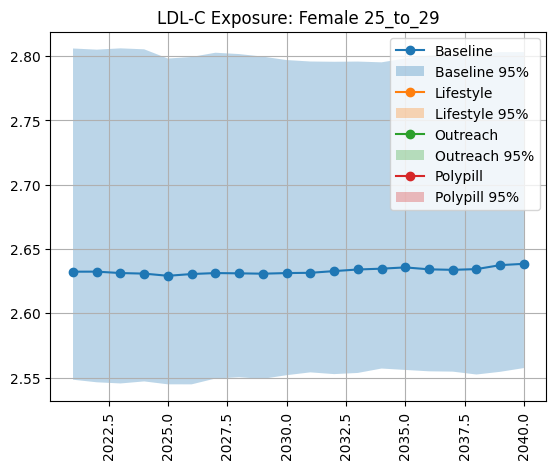

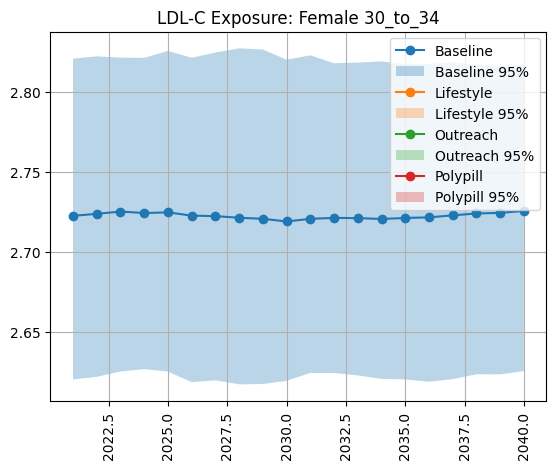

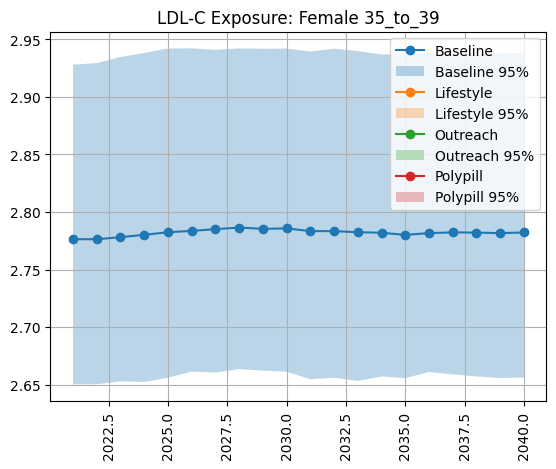

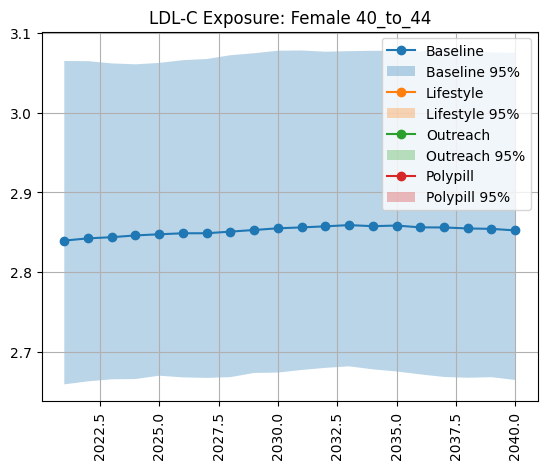

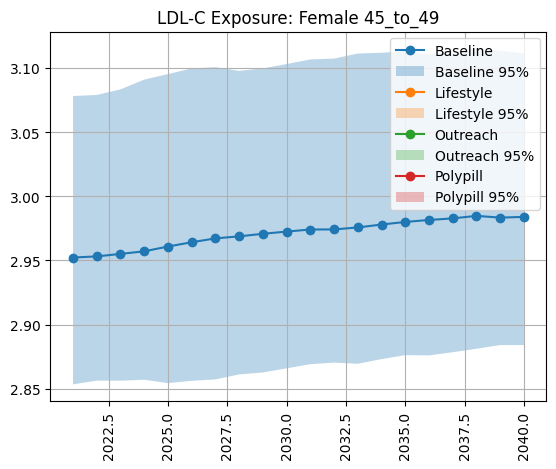

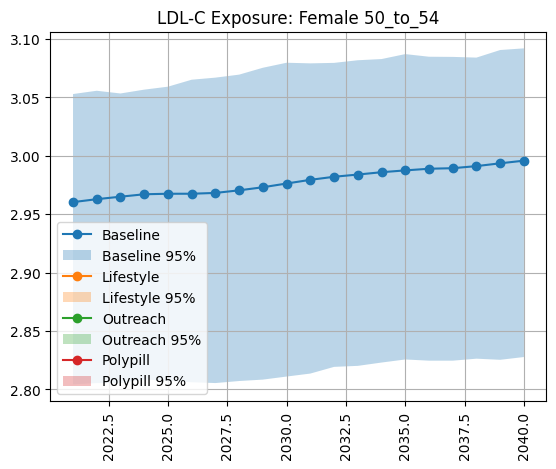

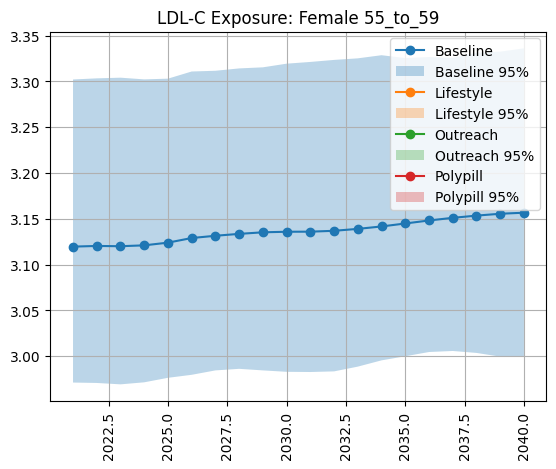

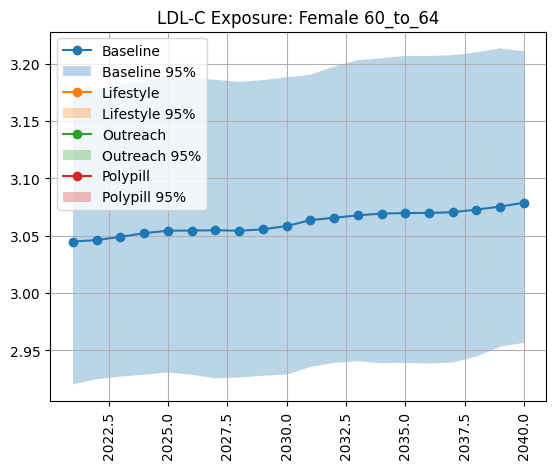

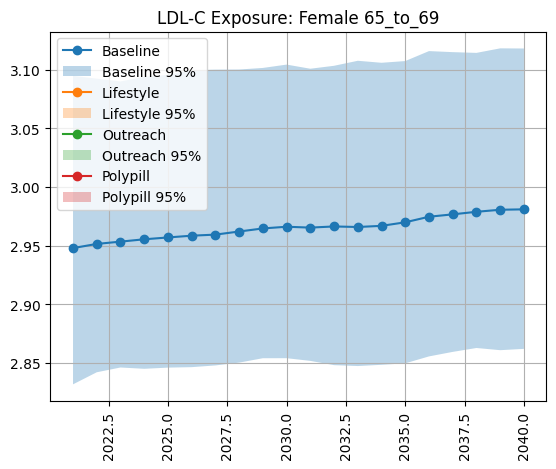

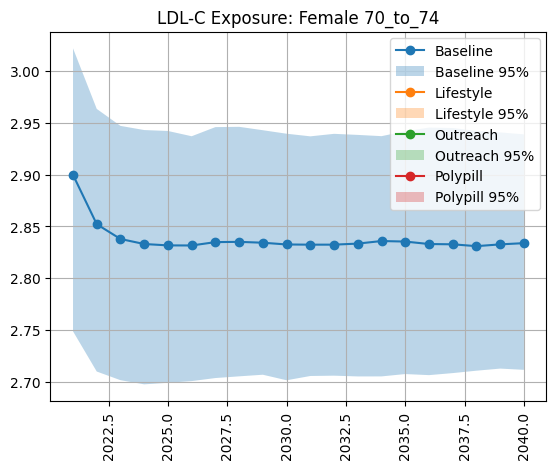

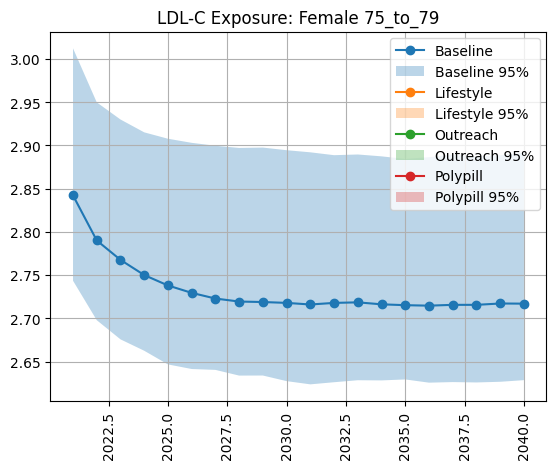

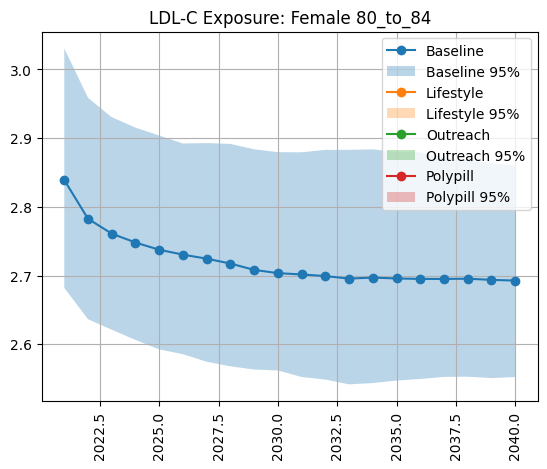

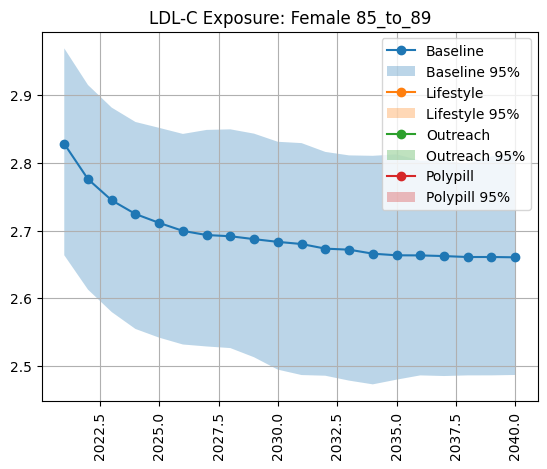

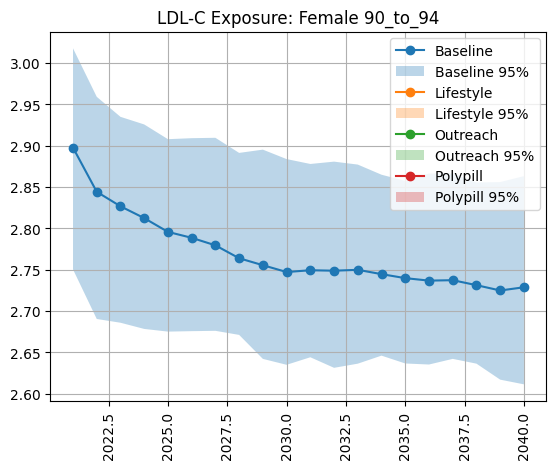

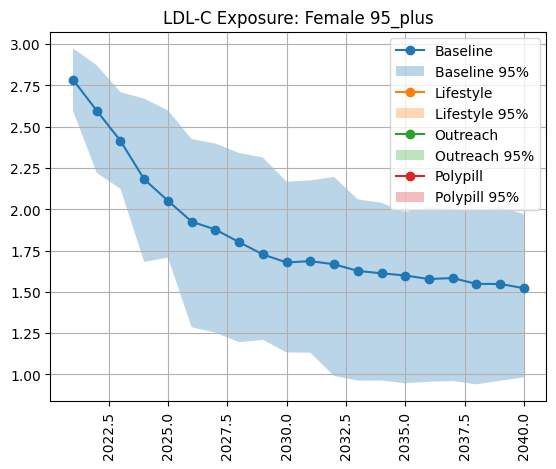

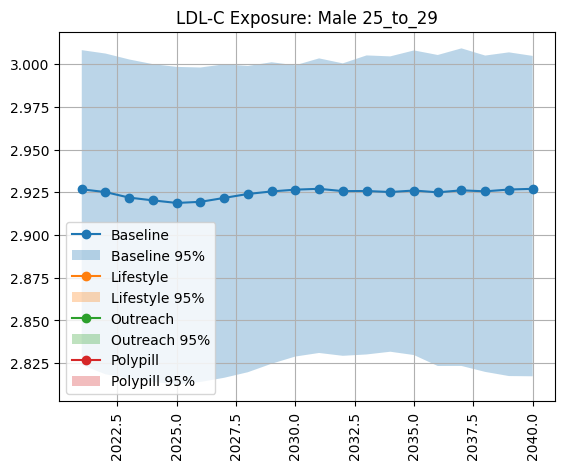

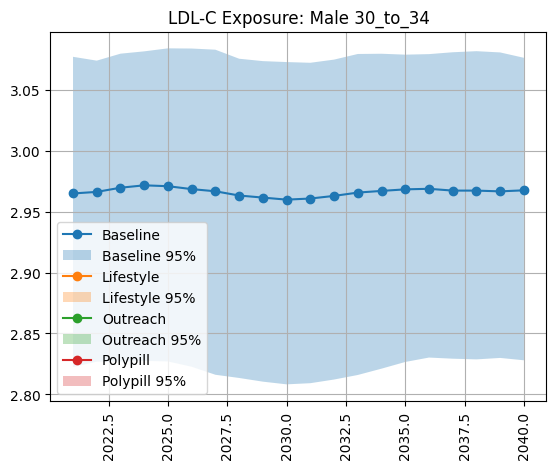

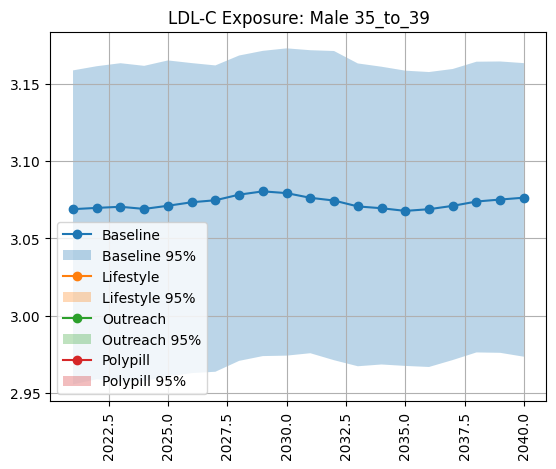

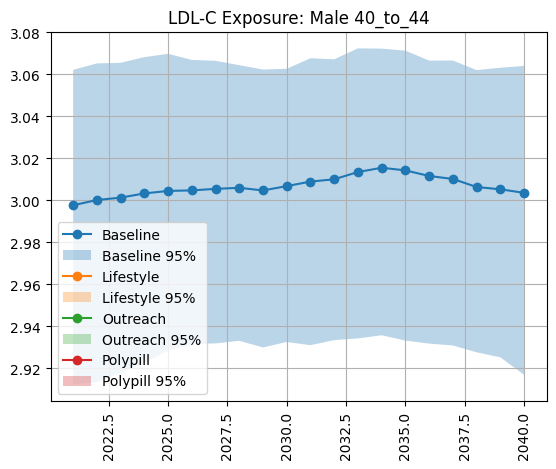

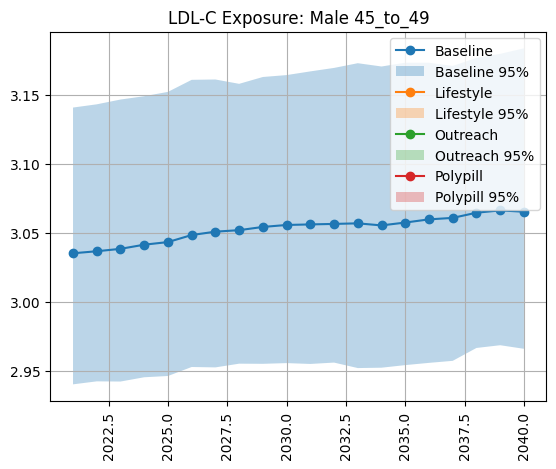

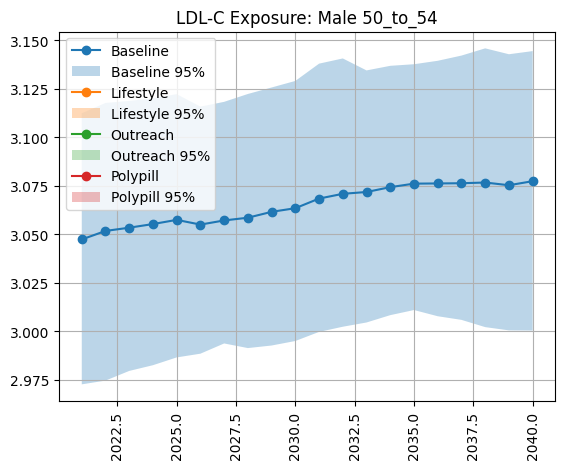

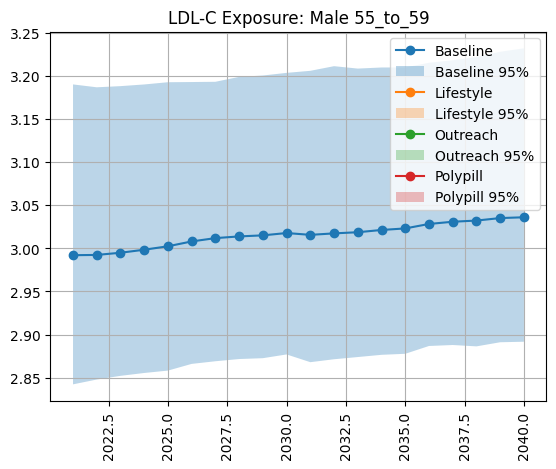

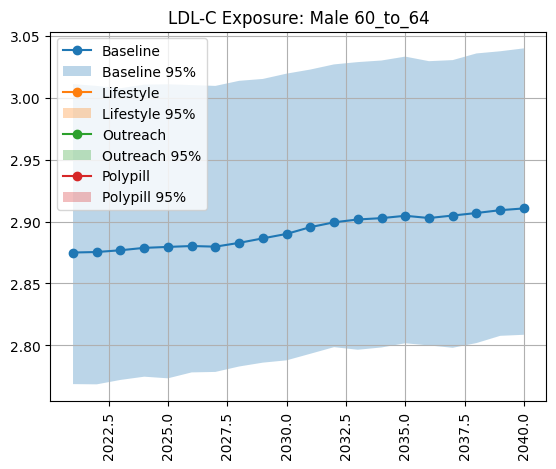

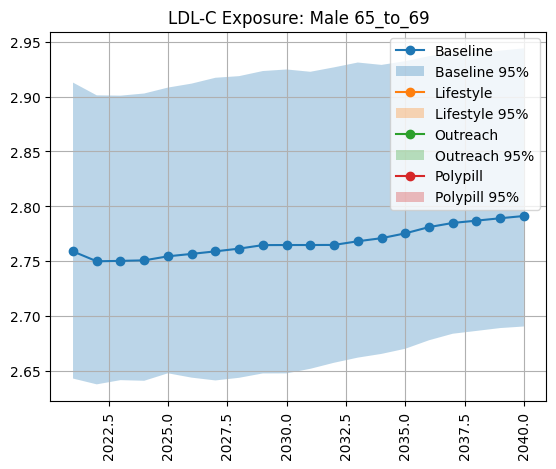

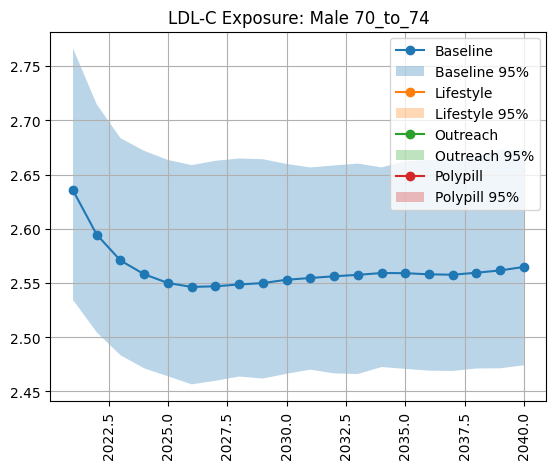

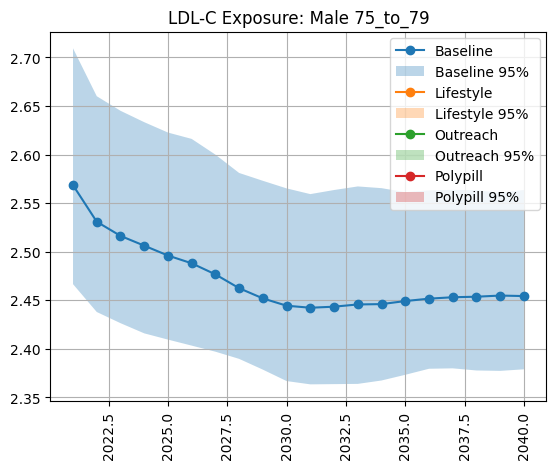

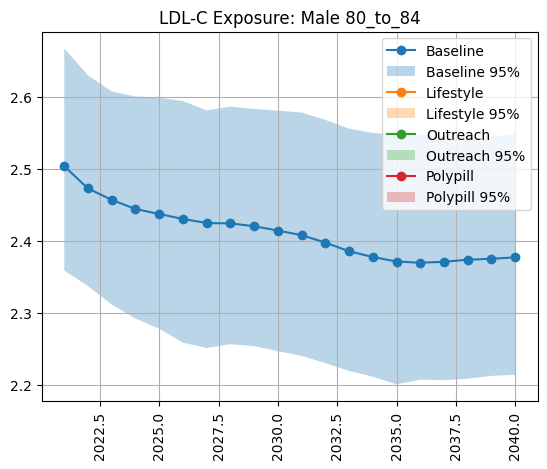

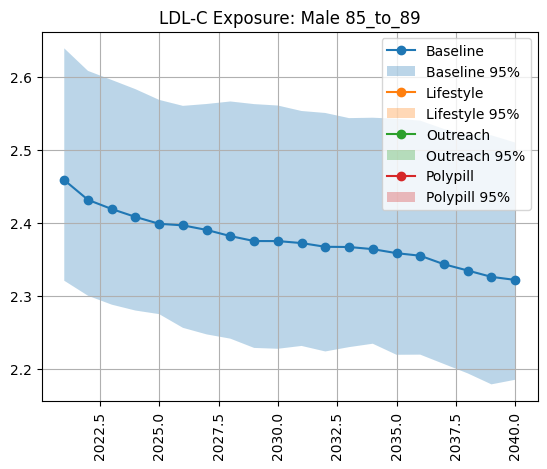

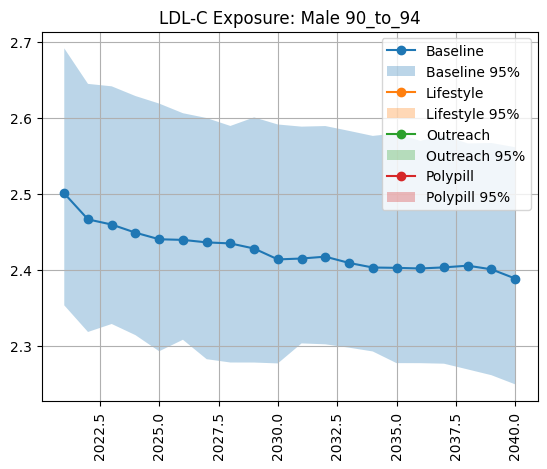

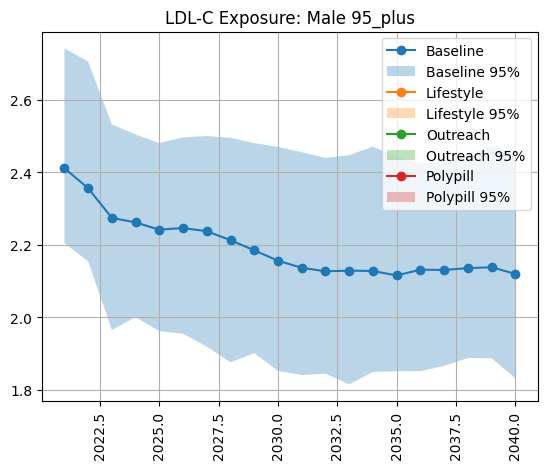

In [12]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age) & (ldl_exp_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
        plt.title(f'LDL-C Exposure: {sex} {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Outreach has the biggest impact. This makes sense with the not yet fixed issues of LDL meds in older adults. Should recheck once those are fixed. 

### FPG

In [13]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

age     sex  year  scenario      mean      2.5%     97.5%
0  25_to_29  Female  2021  baseline  5.338975  4.833254  6.196808
1  25_to_29  Female  2022  baseline  5.341287  4.833031  6.198382
2  25_to_29  Female  2023  baseline  5.338360  4.830665  6.191020
3  25_to_29  Female  2024  baseline  5.339179  4.832819  6.192856
4  25_to_29  Female  2025  baseline  5.338638  4.833404  6.192413

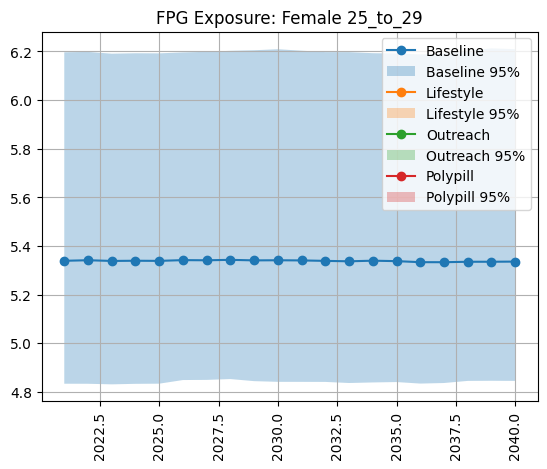

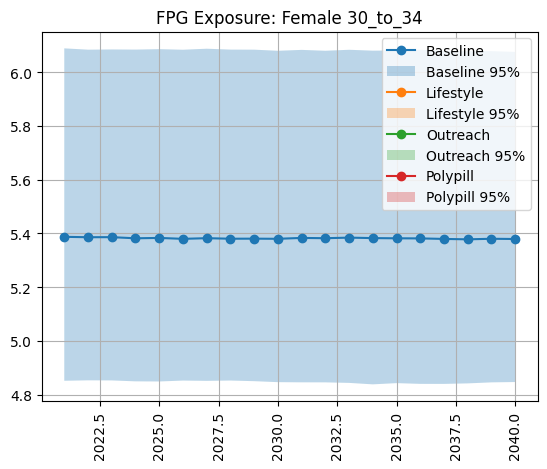

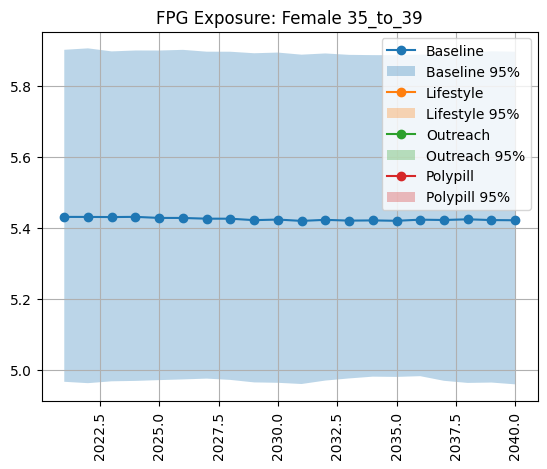

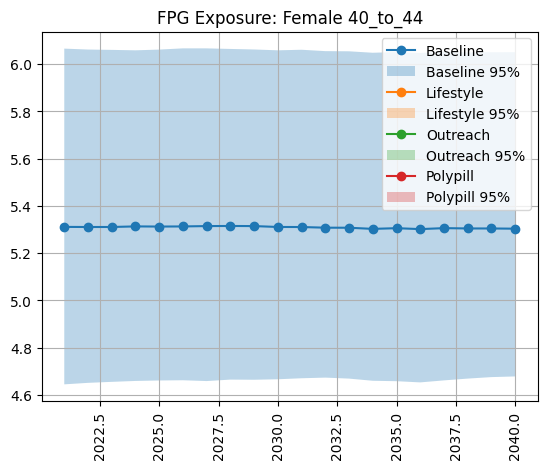

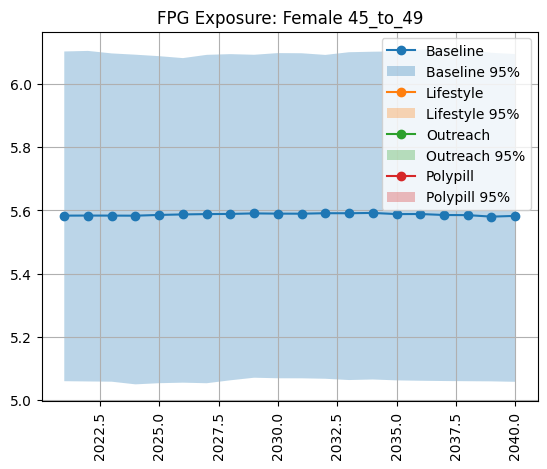

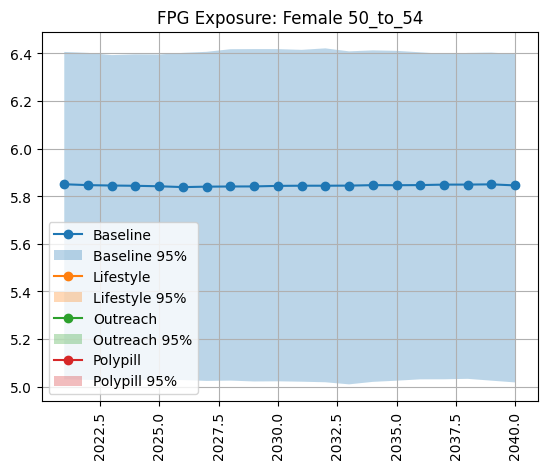

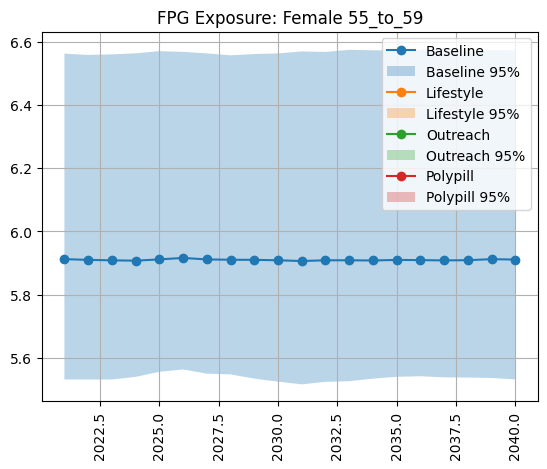

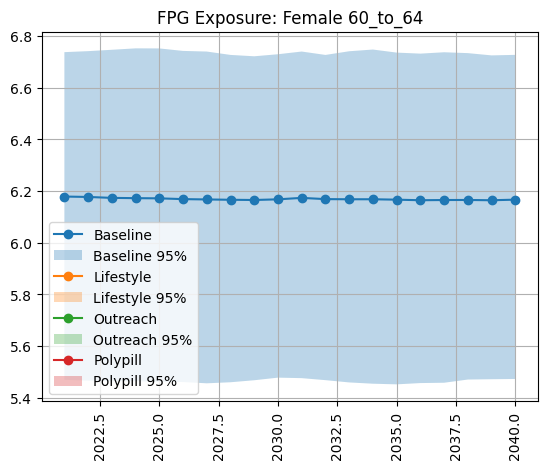

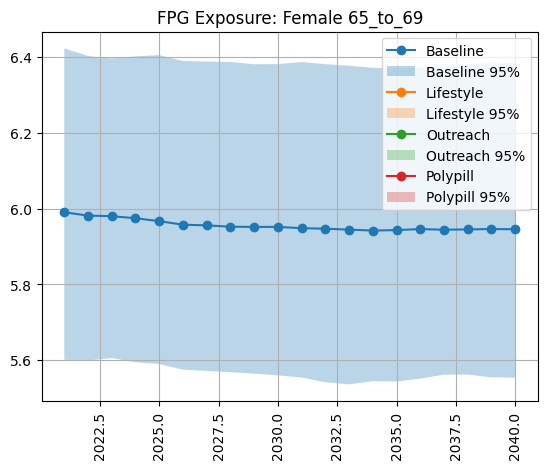

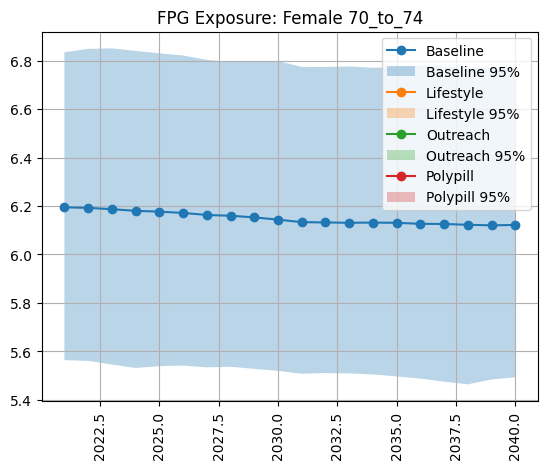

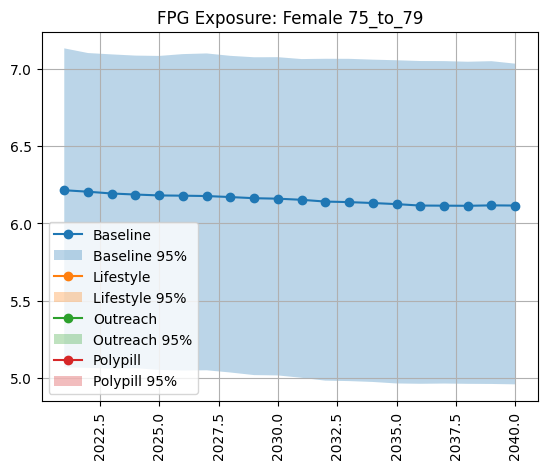

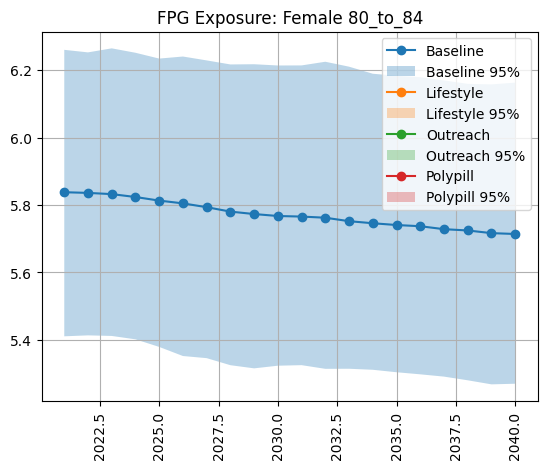

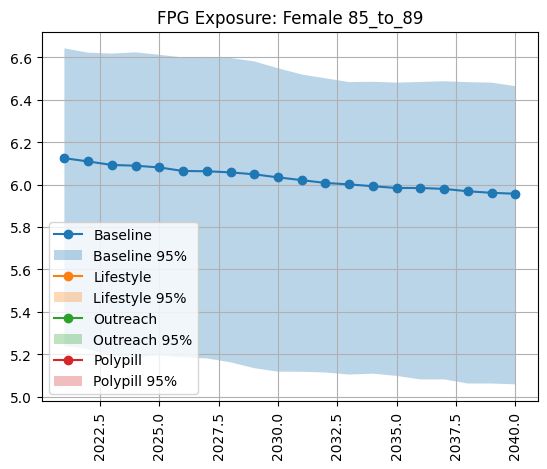

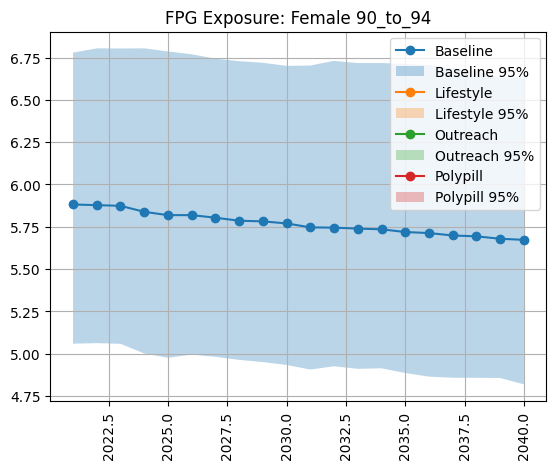

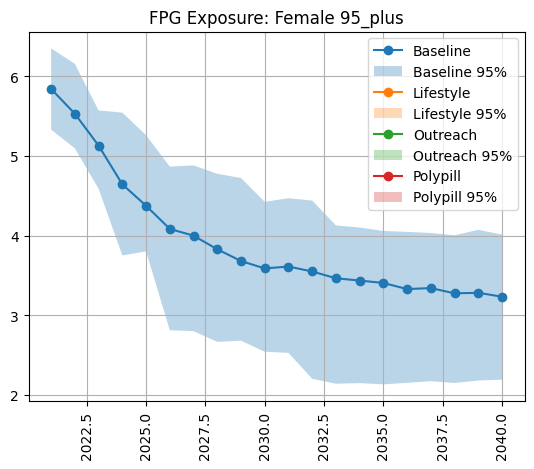

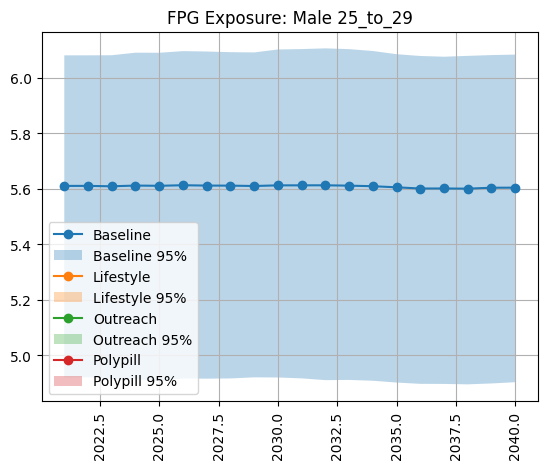

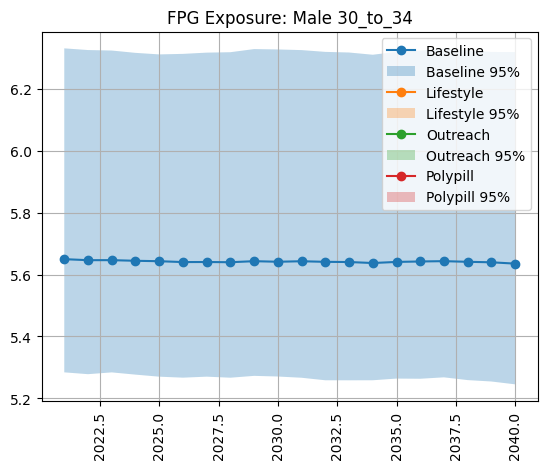

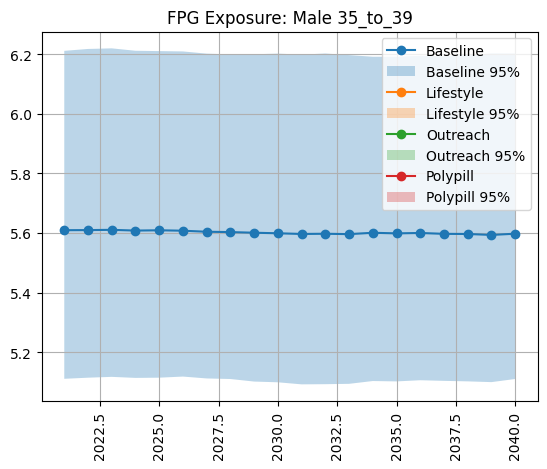

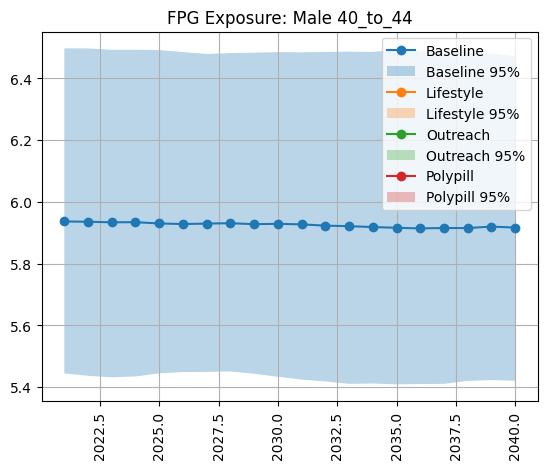

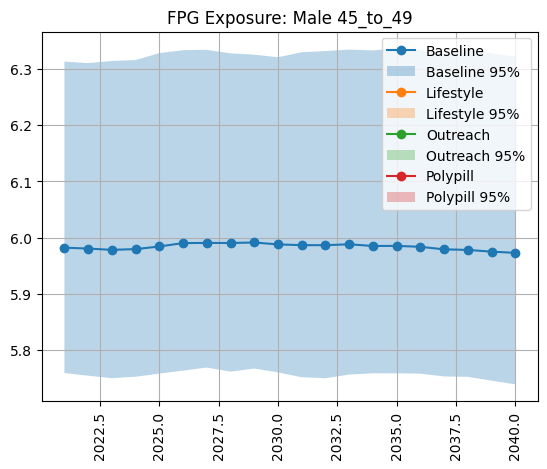

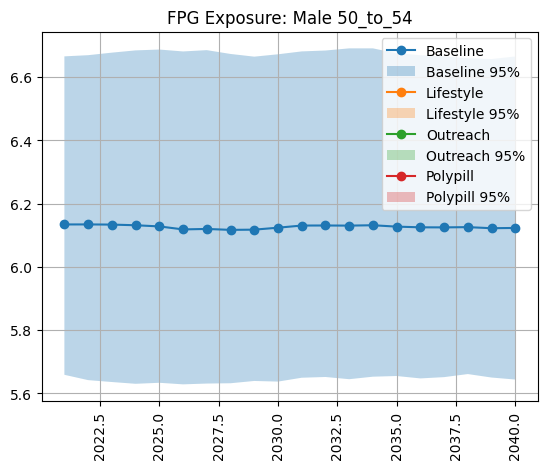

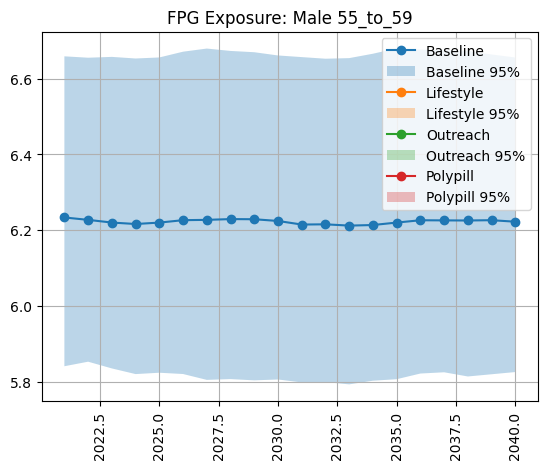

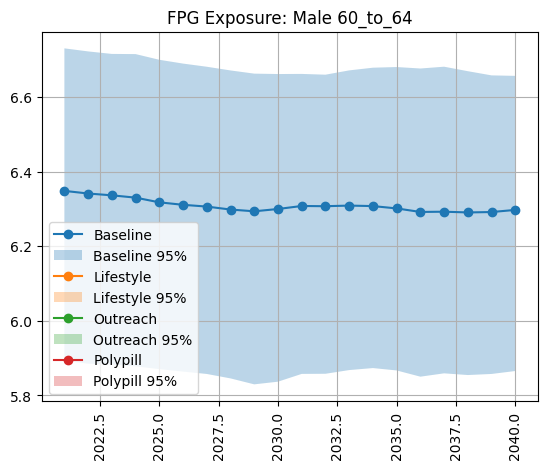

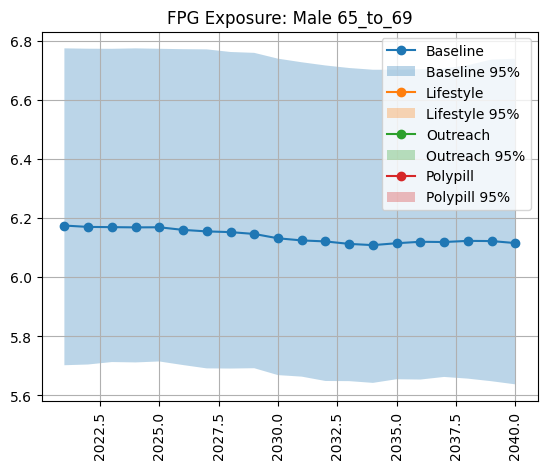

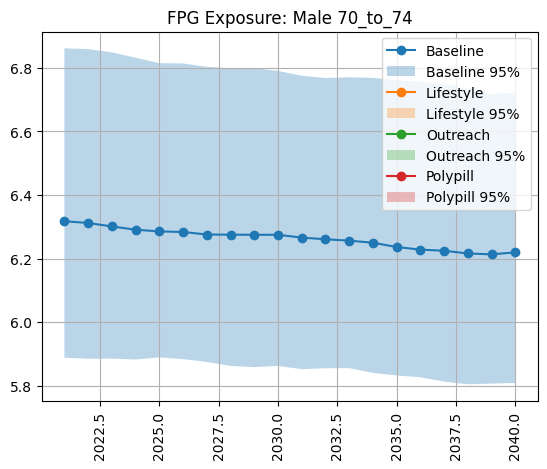

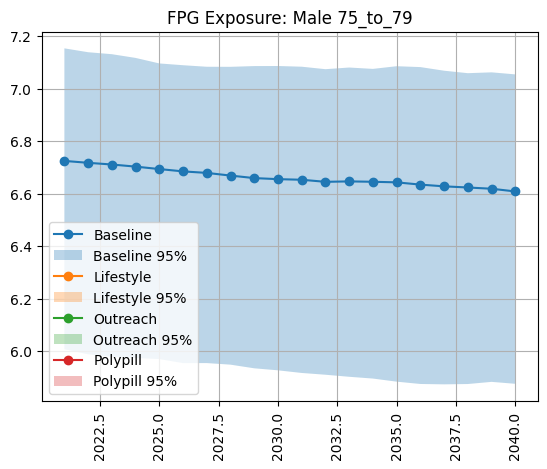

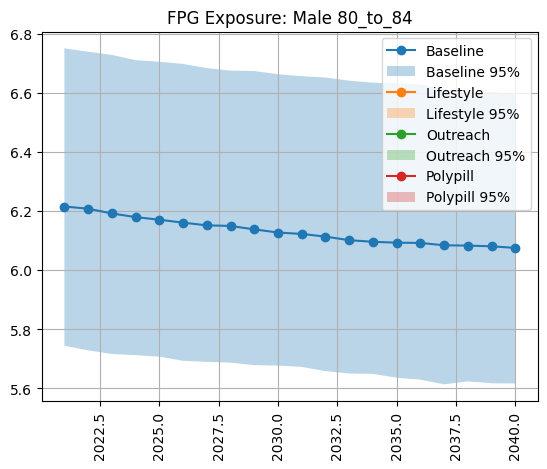

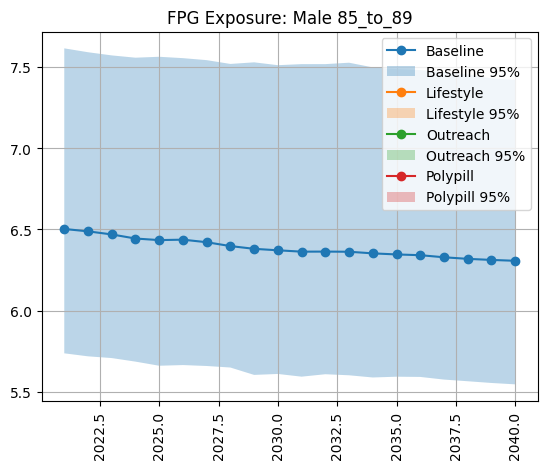

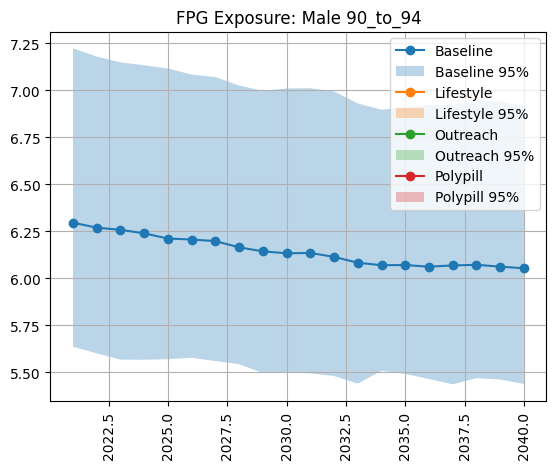

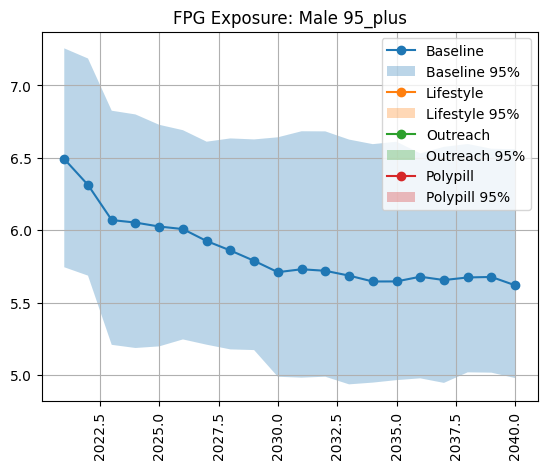

In [14]:
#%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
        plt.title(f'FPG Exposure: {sex} {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Very modest improvments for lifestyle intervention. 

## Comparison to Artifacts

In [15]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v3-20231013/

ls: cannot access '/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v3-20231013/': No such file or directory


In [16]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama-vv-mediation.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [17]:
#art.keys

In [18]:
locations = ['alabama']

In [19]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama-vv-mediation.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i#.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [20]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

sex  age_start  age_end  year_start  year_end   parameter       mean  \
0  Female       25.0     30.0        2019      2020  continuous  30.899912   
1  Female       30.0     35.0        2019      2020  continuous  31.636913   
2  Female       35.0     40.0        2019      2020  continuous  31.883495   
3  Female       40.0     45.0        2019      2020  continuous  32.130649   
4  Female       45.0     50.0        2019      2020  continuous  32.169931   

         50%       2.5%      97.5% location   measure age_group  
0  30.892990  30.572156  31.233780  alabama  exposure  25_to_29  
1  31.638236  31.293987  31.989474  alabama  exposure  30_to_34  
2  31.884883  31.555235  32.210906  alabama  exposure  35_to_39  
3  32.123262  31.801051  32.462829  alabama  exposure  40_to_44  
4  32.165649  31.855765  32.505542  alabama  exposure  45_to_49

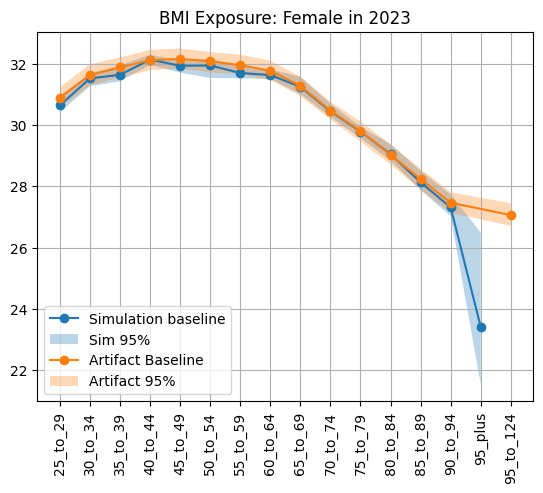

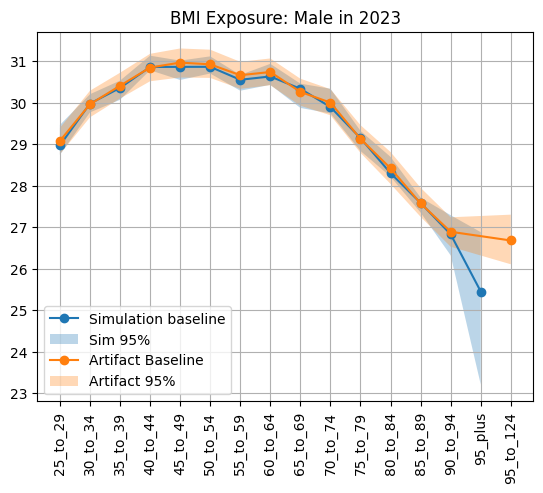

In [21]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023) & (bmi_exp_rate_summ.scenario == 'baseline')]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [22]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  Female       25.0     30.0        2019      2020  continuous  110.635893   
1  Female       30.0     35.0        2019      2020  continuous  112.876275   
2  Female       35.0     40.0        2019      2020  continuous  116.139886   
3  Female       40.0     45.0        2019      2020  continuous  118.491616   
4  Female       45.0     50.0        2019      2020  continuous  121.645391   

          50%        2.5%       97.5% location   measure age_group  
0  110.623634  107.945700  113.550750  alabama  exposure  25_to_29  
1  112.881309  110.098198  115.523727  alabama  exposure  30_to_34  
2  116.134678  113.594023  118.770064  alabama  exposure  35_to_39  
3  118.514616  115.903577  121.039457  alabama  exposure  40_to_44  
4  121.618436  118.875235  124.529834  alabama  exposure  45_to_49

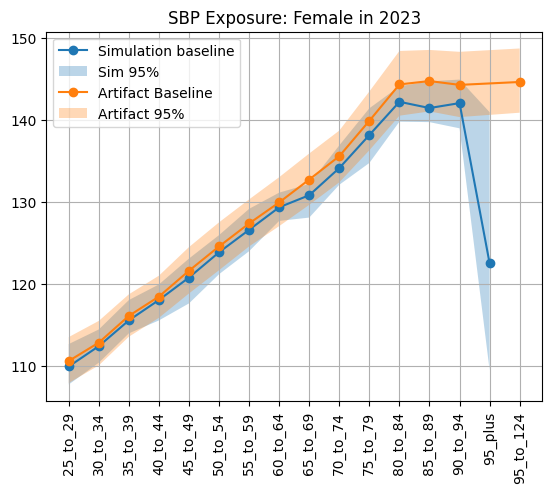

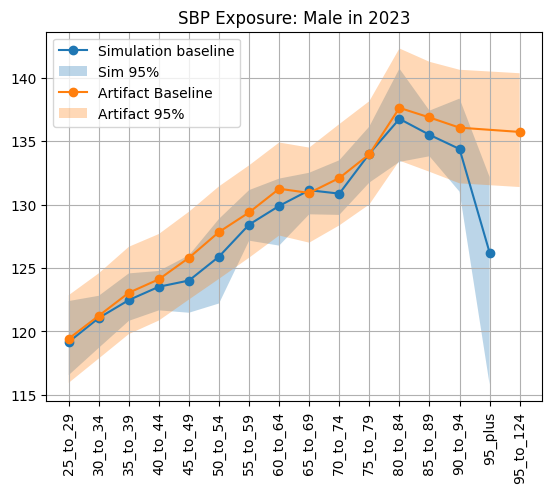

In [23]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023) & (sbp_exp_rate_summ.scenario == 'baseline')]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [24]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  2.639862   
1  Female       30.0     35.0        2019      2020  continuous  2.724353   
2  Female       35.0     40.0        2019      2020  continuous  2.802925   
3  Female       40.0     45.0        2019      2020  continuous  2.880791   
4  Female       45.0     50.0        2019      2020  continuous  2.998297   

        50%      2.5%     97.5% location   measure age_group  
0  2.638003  2.472574  2.821188  alabama  exposure  25_to_29  
1  2.723671  2.553736  2.905134  alabama  exposure  30_to_34  
2  2.801341  2.639513  2.972487  alabama  exposure  35_to_39  
3  2.878250  2.721814  3.039119  alabama  exposure  40_to_44  
4  2.995129  2.837974  3.175367  alabama  exposure  45_to_49

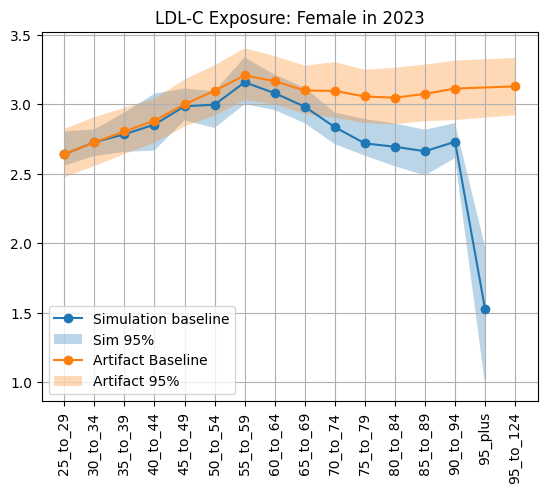

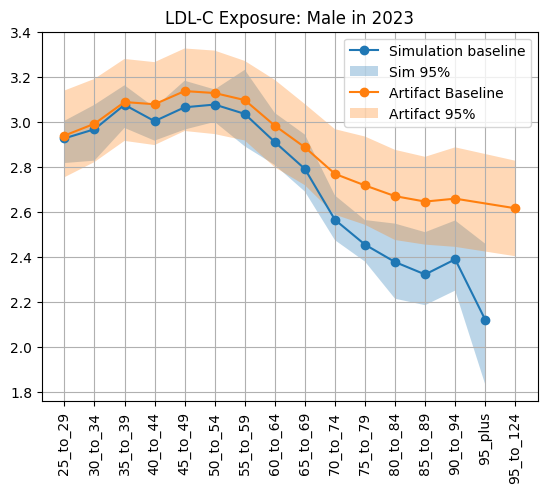

In [25]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040) & (ldl_exp_rate_summ.scenario == 'baseline')]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [26]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  5.316303   
1  Female       30.0     35.0        2019      2020  continuous  5.461718   
2  Female       35.0     40.0        2019      2020  continuous  5.538952   
3  Female       40.0     45.0        2019      2020  continuous  5.659873   
4  Female       45.0     50.0        2019      2020  continuous  5.787248   

        50%      2.5%     97.5% location   measure age_group  
0  5.307507  4.613215  6.137399  alabama  exposure  25_to_29  
1  5.447329  4.696085  6.297658  alabama  exposure  30_to_34  
2  5.538472  4.750516  6.371252  alabama  exposure  35_to_39  
3  5.650779  4.873814  6.494619  alabama  exposure  40_to_44  
4  5.771666  5.004493  6.682187  alabama  exposure  45_to_49

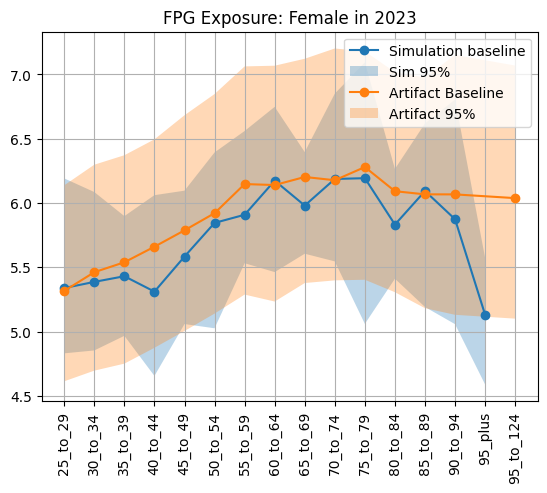

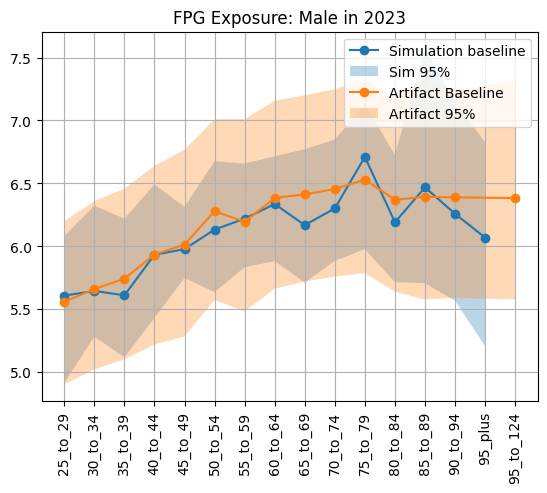

In [27]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023) & (fpg_exp_rate_summ.scenario == 'baseline')]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad